# Курс "Методы современной прикладной статистики"
# 3 курс ФПМИ МФТИ, весна 2022
## Домашнее задание 5. Корреляционный анализ.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as spss
import seaborn as sns
import pandas as pd
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina"  # only for retina display

In [47]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize, fmin

In [48]:
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
from sklearn.ensemble import IsolationForest

### Задача 1

Будем использовать метод таблиц сопряженности.  Создадим таблицу, а затем воспользуемся chi2_contingency.

In [49]:
table = np.array([[13, 35, 26, 46],[22, 45, 48, 75], [18, 30, 15, 47], [44, 62, 56, 68]])

In [50]:
sps.chi2_contingency(table)

(16.275891254401127,
 0.06133904461935207,
 9,
 array([[17.90769231, 31.75384615, 26.76923077, 43.56923077],
        [28.35384615, 50.27692308, 42.38461538, 68.98461538],
        [16.41538462, 29.10769231, 24.53846154, 39.93846154],
        [34.32307692, 60.86153846, 51.30769231, 83.50769231]]))

Как мы можем заметить, pvalue оказался больше заданного уровня значимости, а значит гипотеза о независимости неотвергается.

### Задача 2

Для начала считаем данные и посморим на них:

In [51]:
al = 0.05

In [52]:
data1 = np.load("hw5t2a.npy")

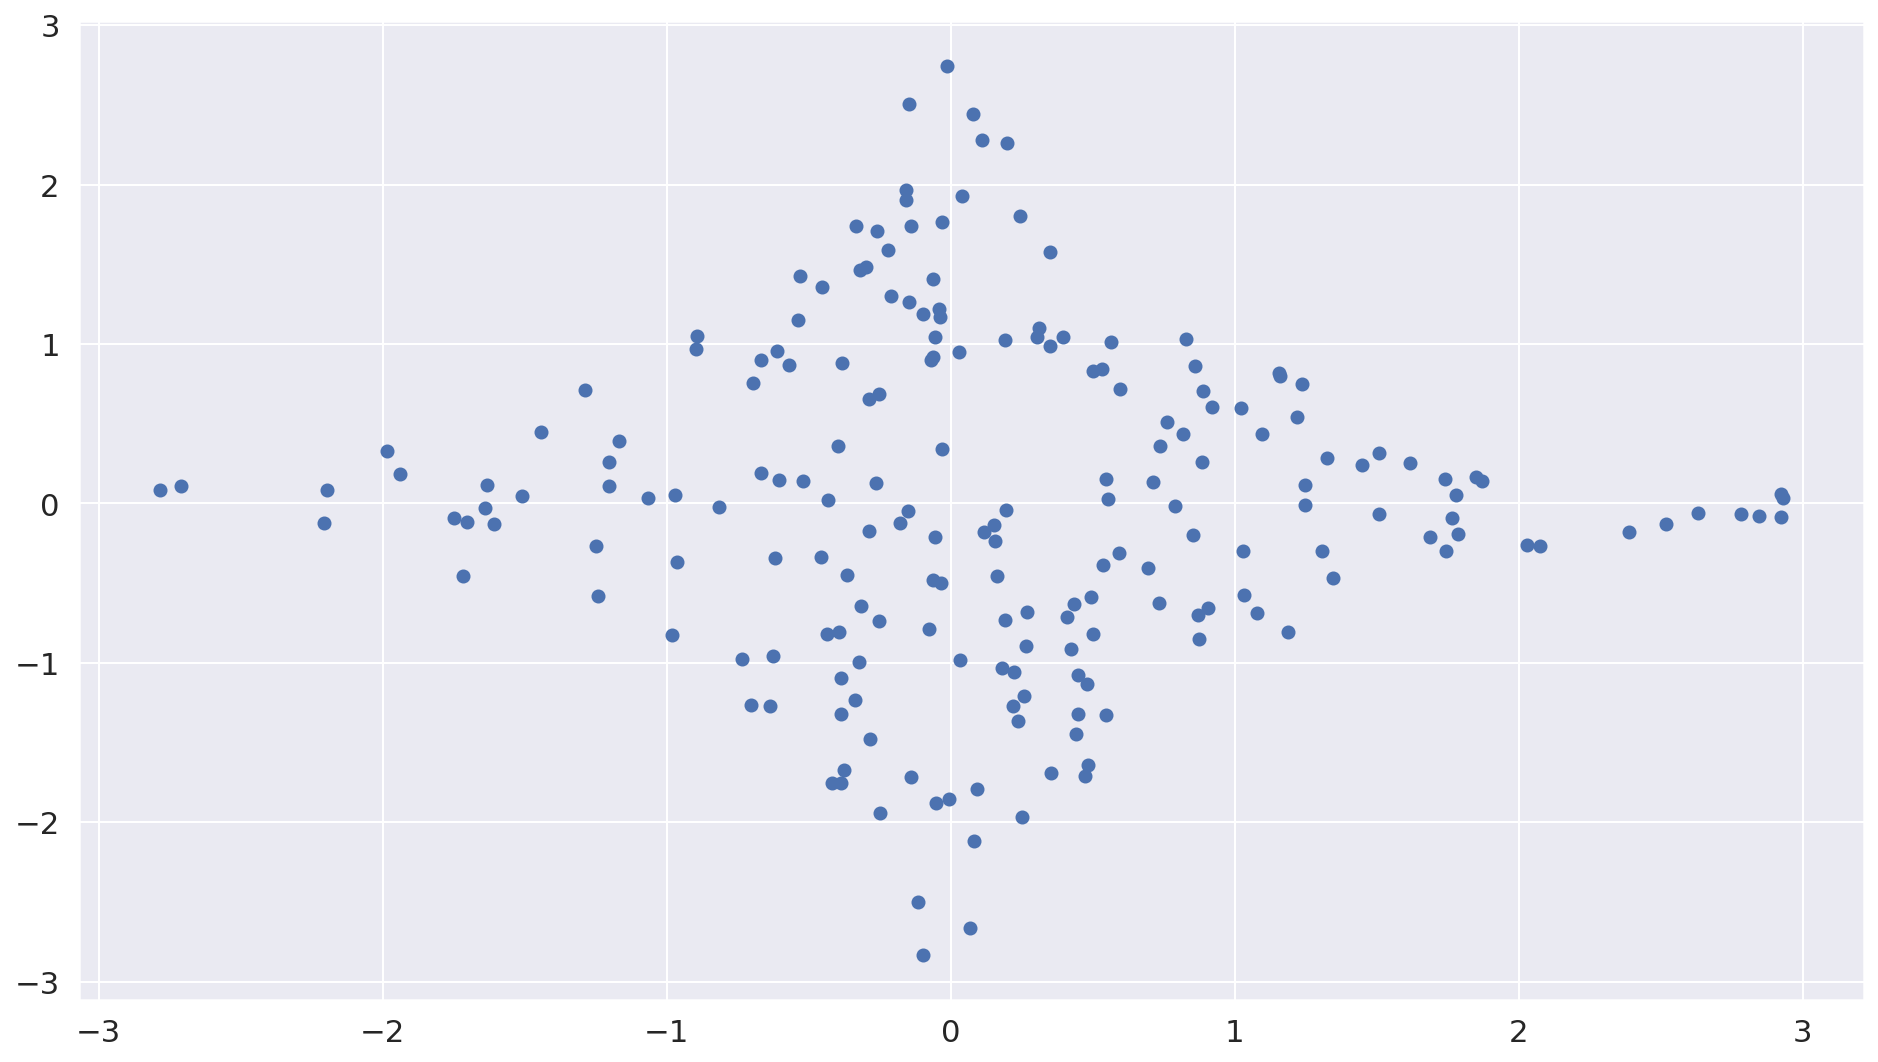

In [53]:
plt.figure(figsize = (16, 9))
plt.scatter(data1[:, 0], data1[: ,1])
plt.show()

Кажется, что зависимость есть (нариована звезда, подозрение на симметричность), но она и не мотонная, и не линейная. А значит, следует применять таблицы сопряженности. 

In [54]:
data_to_frame = {"x" : data1[: , 0], "y": data1[: , 1]}
frame = pd.DataFrame(data=data_to_frame)
frame.head()

,x,y
0,-0.970972,0.050214
1,-0.696865,0.752624
2,1.218057,0.539155
3,1.509003,0.314469
4,0.494606,-0.588871


In [55]:
frame['x_bin'] = pd.cut(frame['x'], [-np.inf, -0.8, 0.8, np.inf])
frame['y_bin'] = pd.cut(frame['y'], [-np.inf, -0.8, 0.8, np.inf])

In [56]:
table = frame.pivot_table(values='x', index='x_bin', columns='y_bin', aggfunc='count', fill_value=0)
table

y_bin,"(-inf, -0.8]","(-0.8, 0.8]","(0.8, inf]"
x_bin,,,
"(-inf, -0.8]",1,24,2
"(-0.8, 0.8]",41,43,42
"(0.8, inf]",2,42,3


In [57]:
sps.chi2_contingency(table)

(57.15257424912672,
 1.1492641040039787e-11,
 4,
 array([[ 5.94 , 14.715,  6.345],
        [27.72 , 68.67 , 29.61 ],
        [10.34 , 25.615, 11.045]]))

Как мы можем заметить, pvalue оказался меньше заданного уровня значимости, а значит гипотеза о независимости отвергается.

Перейдем ко второй паре выборок.

In [58]:
data2 = np.load("hw5t2b.npy")

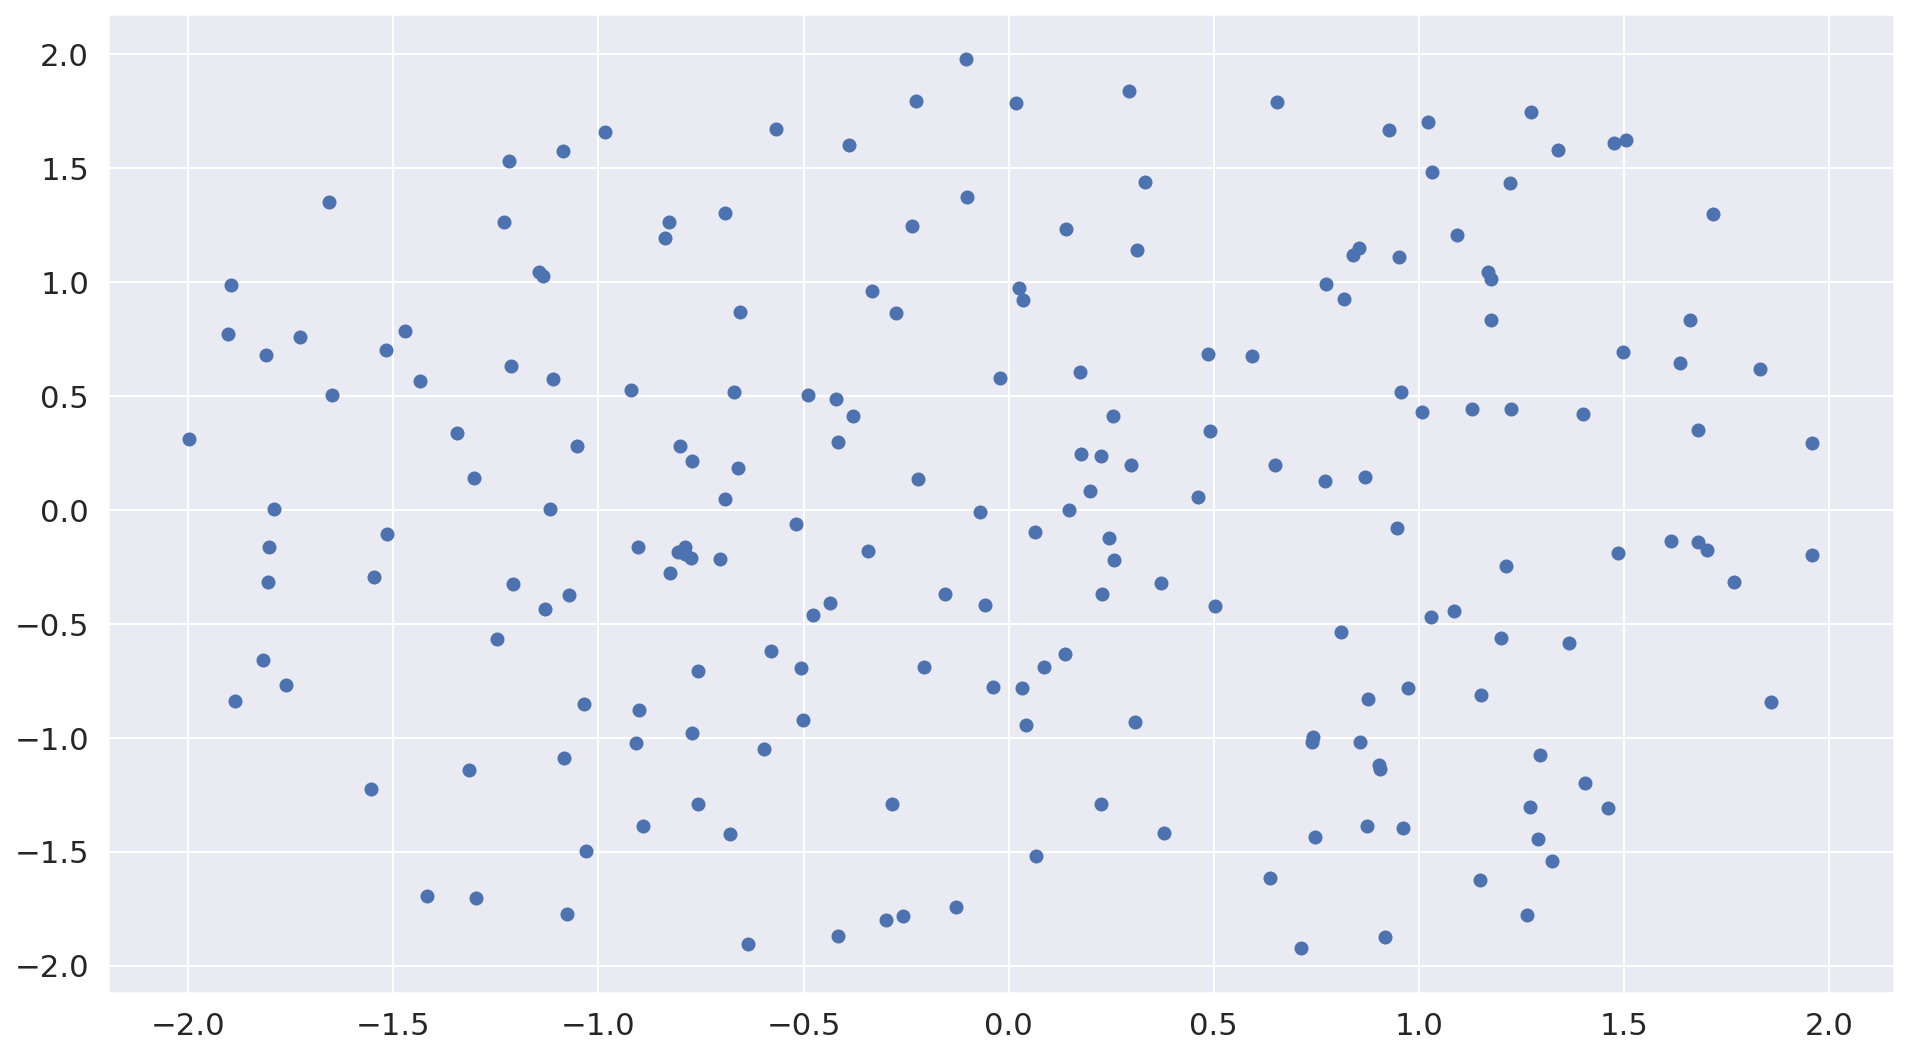

In [59]:
plt.figure(figsize = (16, 9))
plt.scatter(data2[:, 0], data2[: ,1])
plt.show()

Нормальности в данных не наблюдается, выбросов тоже нет. Кажется, что данные независимы. Исходя из этого, будем использовать коэффициент корреляции Спирмена.

In [60]:
sps.spearmanr(data2[:, 0], data2[:, 1])

SpearmanrResult(correlation=0.014712367809195232, pvalue=0.8361884433241937)

Как мы можем заметить, pvalue оказался больше заданного уровня значимости, а значит гипотеза о независимости неотвергается.

### Задача 3

Считаем данные и построим датафрейм.

In [61]:
data = np.load("hw5t3.npy")

In [62]:
data_to_frame = {"name" : data[: , 0], "time": data[: , 1].astype(np.float)}
frame = pd.DataFrame(data=data_to_frame)
frame.head()

,name,time
0,Humpty-Dumpty,20.274644
1,Humpty-Dumpty,10.914941
2,Bandersnatch,12.569895
3,Humpty-Dumpty,23.405772
4,Humpty-Dumpty,2.025679


In [63]:
stats = frame.groupby(by = 'name').count()
stats

,time
name,
Bandersnatch,97
Humpty-Dumpty,75
Mr. Fattakhov,154
Tweedledee and Tweedledum,74


Для каждого персонажа построим гистограмму, чтобы понять как расположены данные. Также сразу хотелось бы отметить, что не стоит делать какие-либо поправки исходя из того, что Фаттахов пьет чай в два раза больше, чем все остальные. Во-первых, не очень понятно к чему именно относятся эти "в два раза", С одной стороны, возможно Алиса имела ввиду в сумме Фаттахов выпил в 2 раза больше, в то время как с другой стороны может иметься ввиду, что когда Фаттахов начинал хотел пить чай, он пил его в два раза быстрее и то есть в два раза быстрее переходил к новой кружке. Но в обоих случаях важно заметить, что эффект вообще не зависит от времени. 

In [64]:
names = frame['name'].unique()
names

array(['Humpty-Dumpty', 'Bandersnatch', 'Tweedledee and Tweedledum',
       'Mr. Fattakhov'], dtype=object)

In [65]:
colors = ['red', 'green', 'blue', 'yellow']

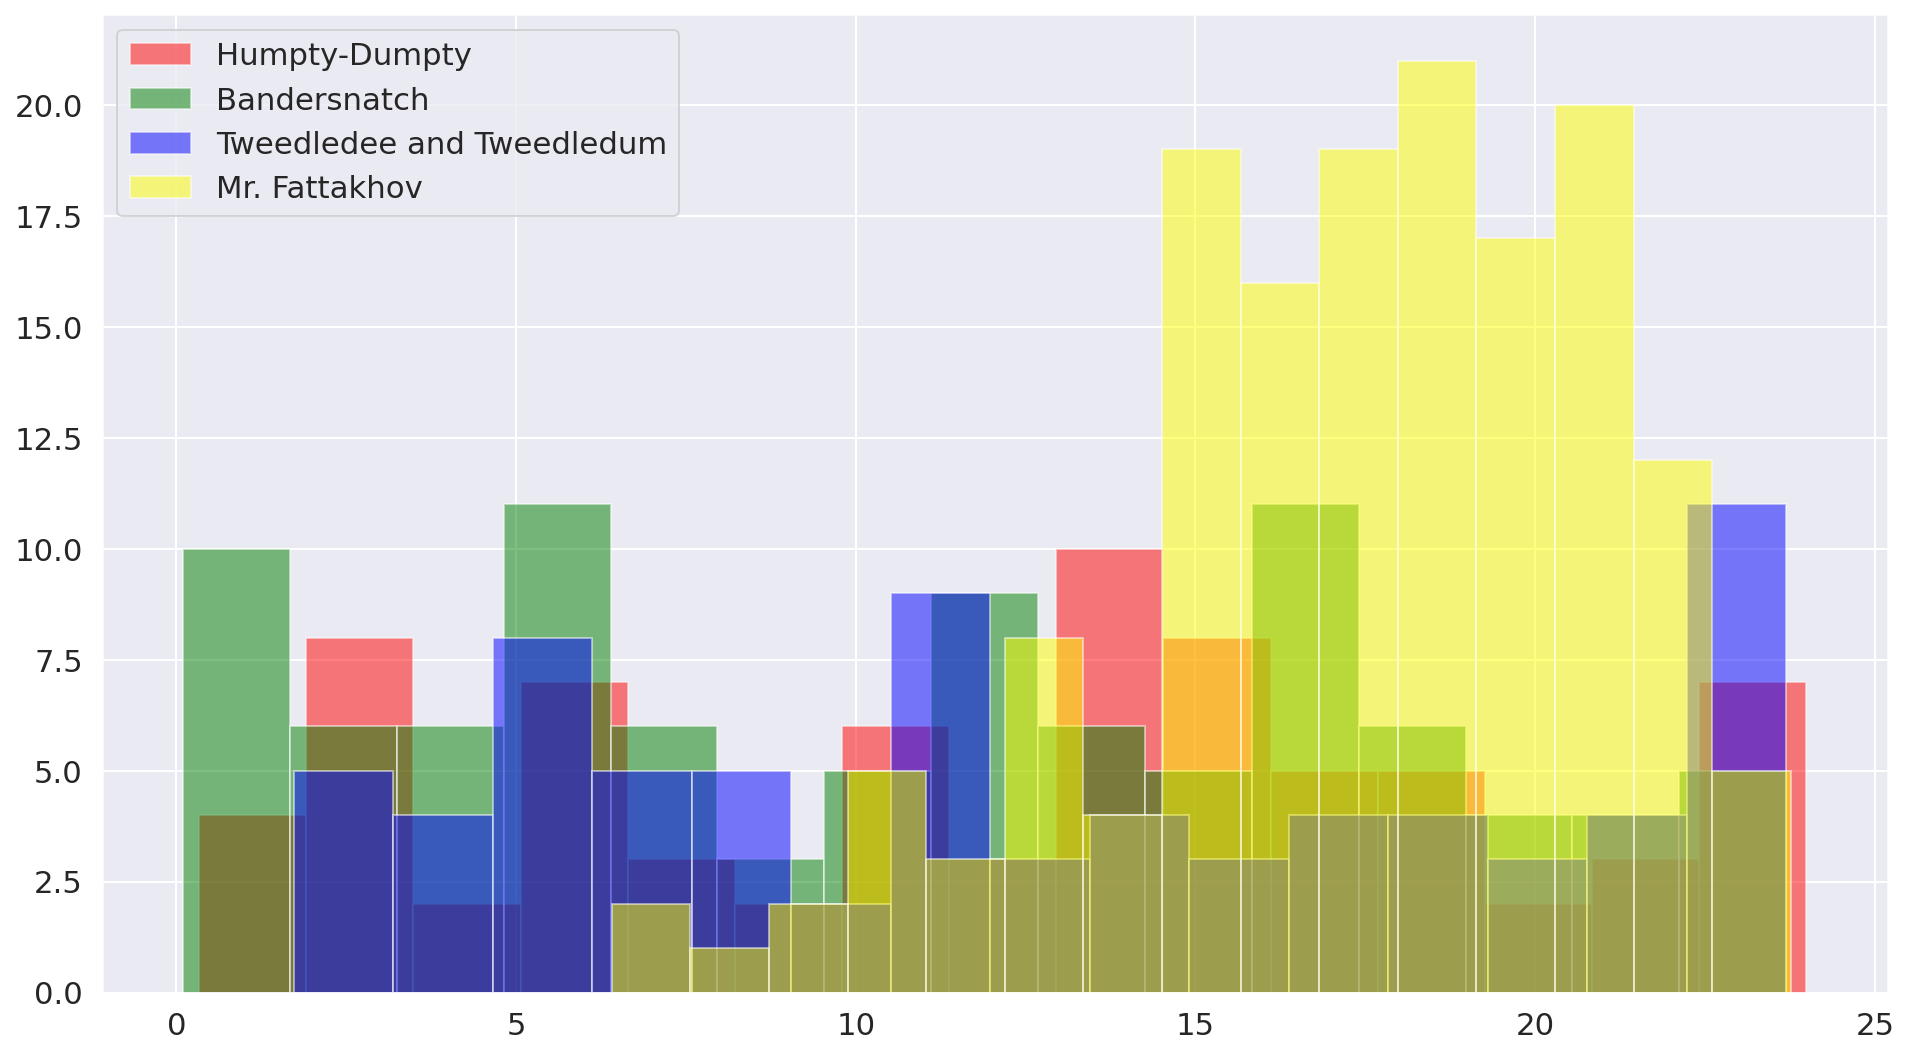

In [66]:
plt.figure(figsize = (16, 9))
for color, name in zip(colors, names):
    need_dat = frame[frame['name'] == name]
    plt.hist(need_dat['time'], bins = 15, alpha = 0.5, label = name, color = color)
plt.legend()
plt.show()

Исходя из гистограммы напрашивается вывод, что для всех вечером Фаттахов пить начинает чай 2.5-3 раза больше. И поэтому кажется, что гипотеза о независимости должна отвергнуться, так как чем ближе к вечеру, тем больше Фаттахов наливает чай, а чем ближе к утру (где-то к 8-9), тем меньше. Проверим, что гипотеза о независимости отвергнется через сопряженные таблицы. Бины будем брать по 3 часа.

In [67]:
frame['time_bin'] = pd.cut(frame['time'], np.arange(0, 25, 3))
frame

,name,time,time_bin
0,Humpty-Dumpty,20.274644,"(18, 21]"
1,Humpty-Dumpty,10.914941,"(9, 12]"
2,Bandersnatch,12.569895,"(12, 15]"
3,Humpty-Dumpty,23.405772,"(21, 24]"
4,Humpty-Dumpty,2.025679,"(0, 3]"
...,...,...,...
395,Humpty-Dumpty,19.213886,"(18, 21]"
396,Bandersnatch,17.016539,"(15, 18]"
397,Tweedledee and Tweedledum,20.407802,"(18, 21]"
398,Bandersnatch,17.893657,"(15, 18]"


In [68]:
table = frame.pivot_table(index='name', columns='time_bin', aggfunc='count', fill_value=0)
table

time                                          \
time_bin                  (0, 3] (3, 6] (6, 9] (9, 12] (12, 15] (15, 18]   
name                                                                       
Bandersnatch                  16     14     11      13       12       17   
Humpty-Dumpty                  8     10      7       8       15       11   
Mr. Fattakhov                  0      0      4       9       20       46   
Tweedledee and Tweedledum      5     11     10      12        7        8   

                                             
time_bin                  (18, 21] (21, 24]  
name                                         
Bandersnatch                     6        8  
Humpty-Dumpty                    7        9  
Mr. Fattakhov                   49       26  
Tweedledee and Tweedledum        6       15

In [69]:
sps.chi2_contingency(table)

(114.91455226885947,
 6.065214451825338e-15,
 21,
 array([[ 7.0325,  8.4875,  7.76  , 10.185 , 13.095 , 19.885 , 16.49  ,
         14.065 ],
        [ 5.4375,  6.5625,  6.    ,  7.875 , 10.125 , 15.375 , 12.75  ,
         10.875 ],
        [11.165 , 13.475 , 12.32  , 16.17  , 20.79  , 31.57  , 26.18  ,
         22.33  ],
        [ 5.365 ,  6.475 ,  5.92  ,  7.77  ,  9.99  , 15.17  , 12.58  ,
         10.73  ]]))

Как видим, гипотеза о независимости отвергается на уровне значимости 0.05.

Если внимательно посмотреть на гистограмму еще раз, то кажется, что если убрать Фаттахова, то  наполнение чашки происходит независимо от времени. Проверим это

In [70]:
table2 = table[table.index != "Mr. Fattakhov"]
sps.chi2_contingency(table2)

(14.82834859224217,
 0.3899883545631667,
 14,
 array([[11.43495935, 13.80081301, 11.04065041, 13.01219512, 13.40650407,
         14.19512195,  7.49186992, 12.61788618],
        [ 8.84146341, 10.67073171,  8.53658537, 10.06097561, 10.36585366,
         10.97560976,  5.79268293,  9.75609756],
        [ 8.72357724, 10.52845528,  8.42276423,  9.92682927, 10.22764228,
         10.82926829,  5.71544715,  9.62601626]]))

Как видим, без Фаттахова гипотеза о независимости на уровне значимости не отвергается, то есть наше предположение подтверждено с точки зрения практики!

### Задача 4

Считаем данные и посмотрим на них.

In [71]:
al = 0.05
data = np.load("hw5t4.npy")

In [72]:
data.shape

(10, 100)

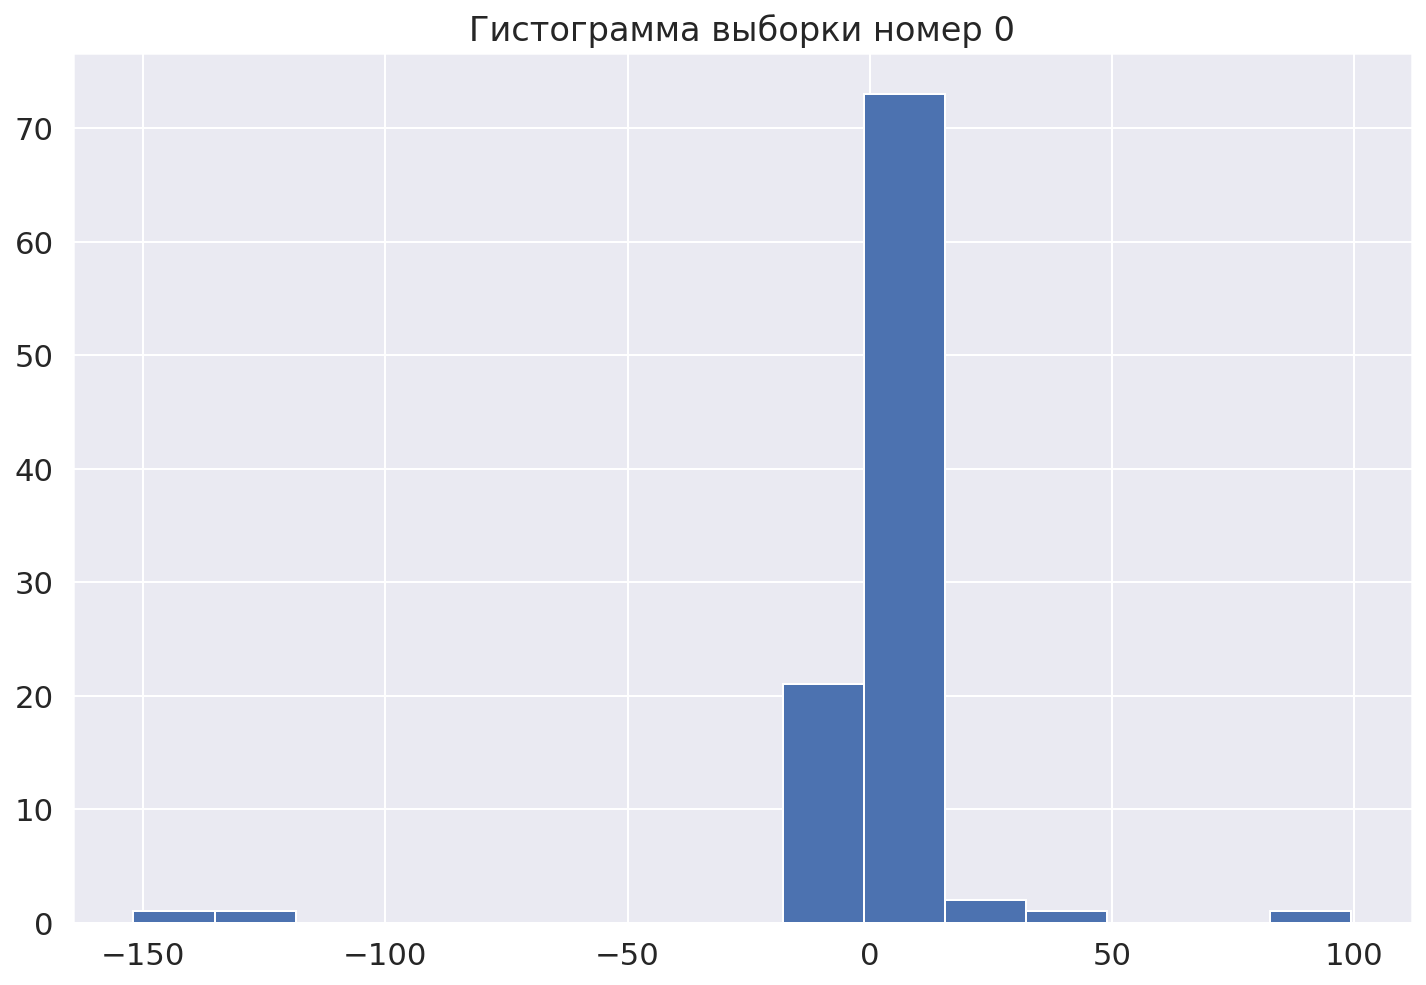

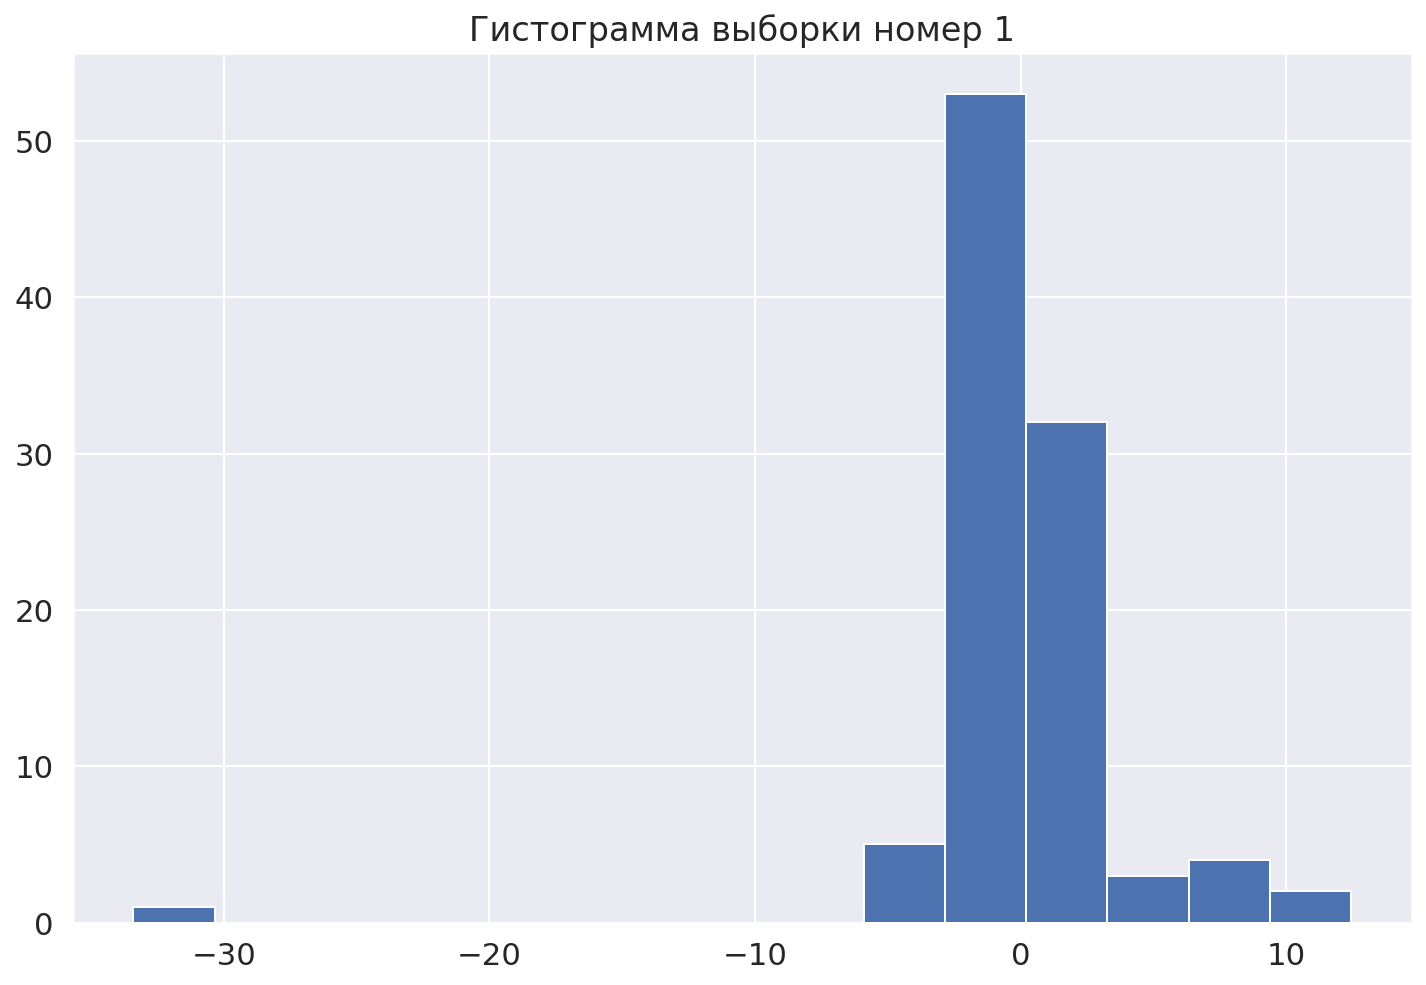

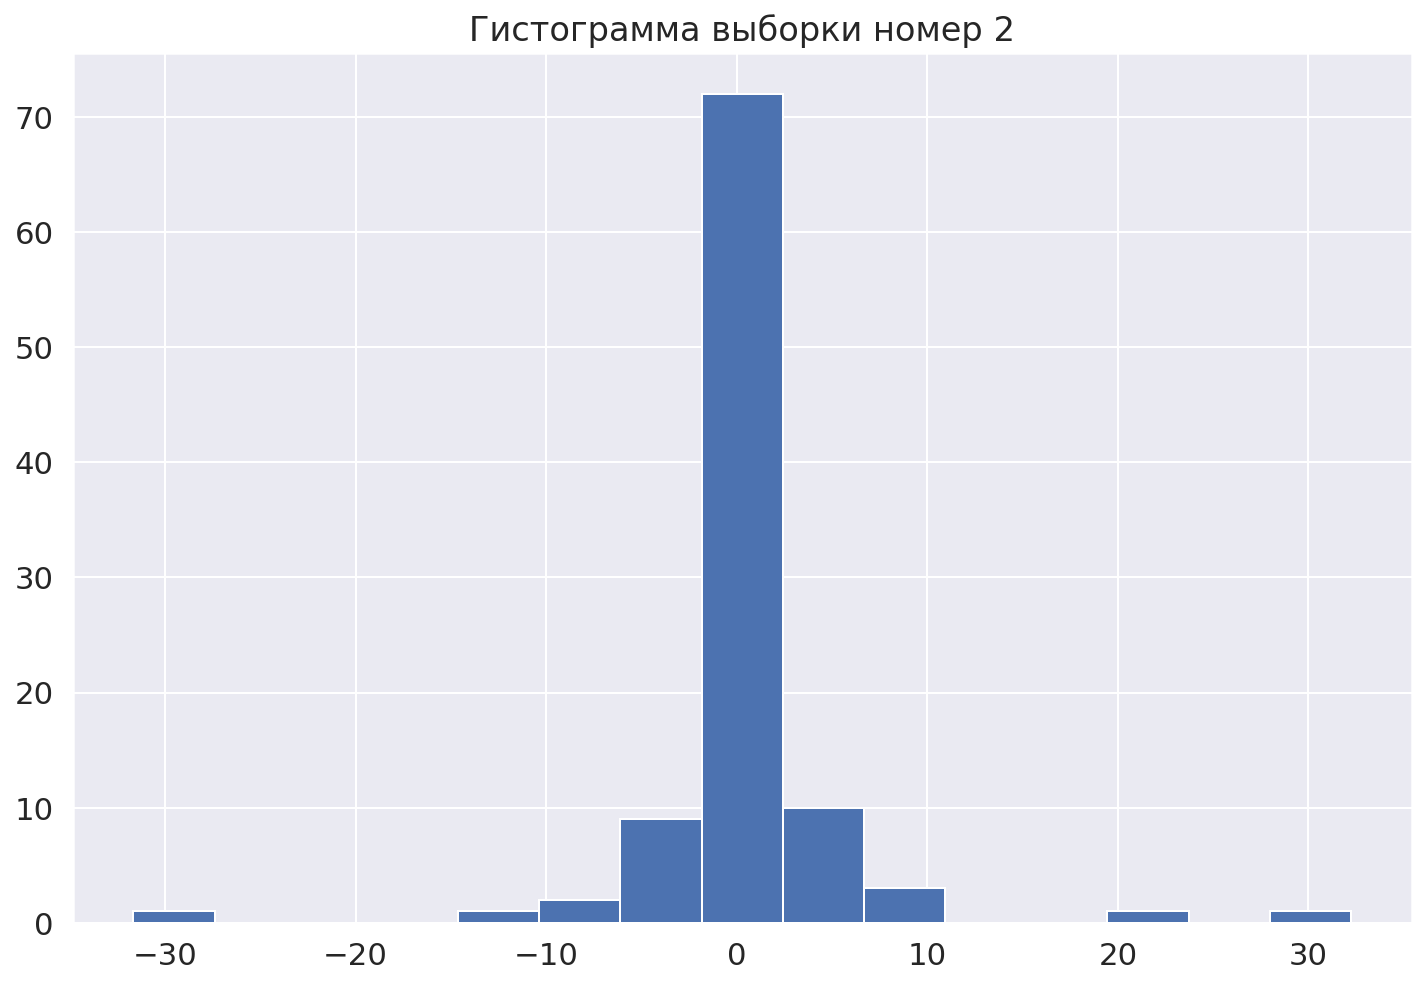

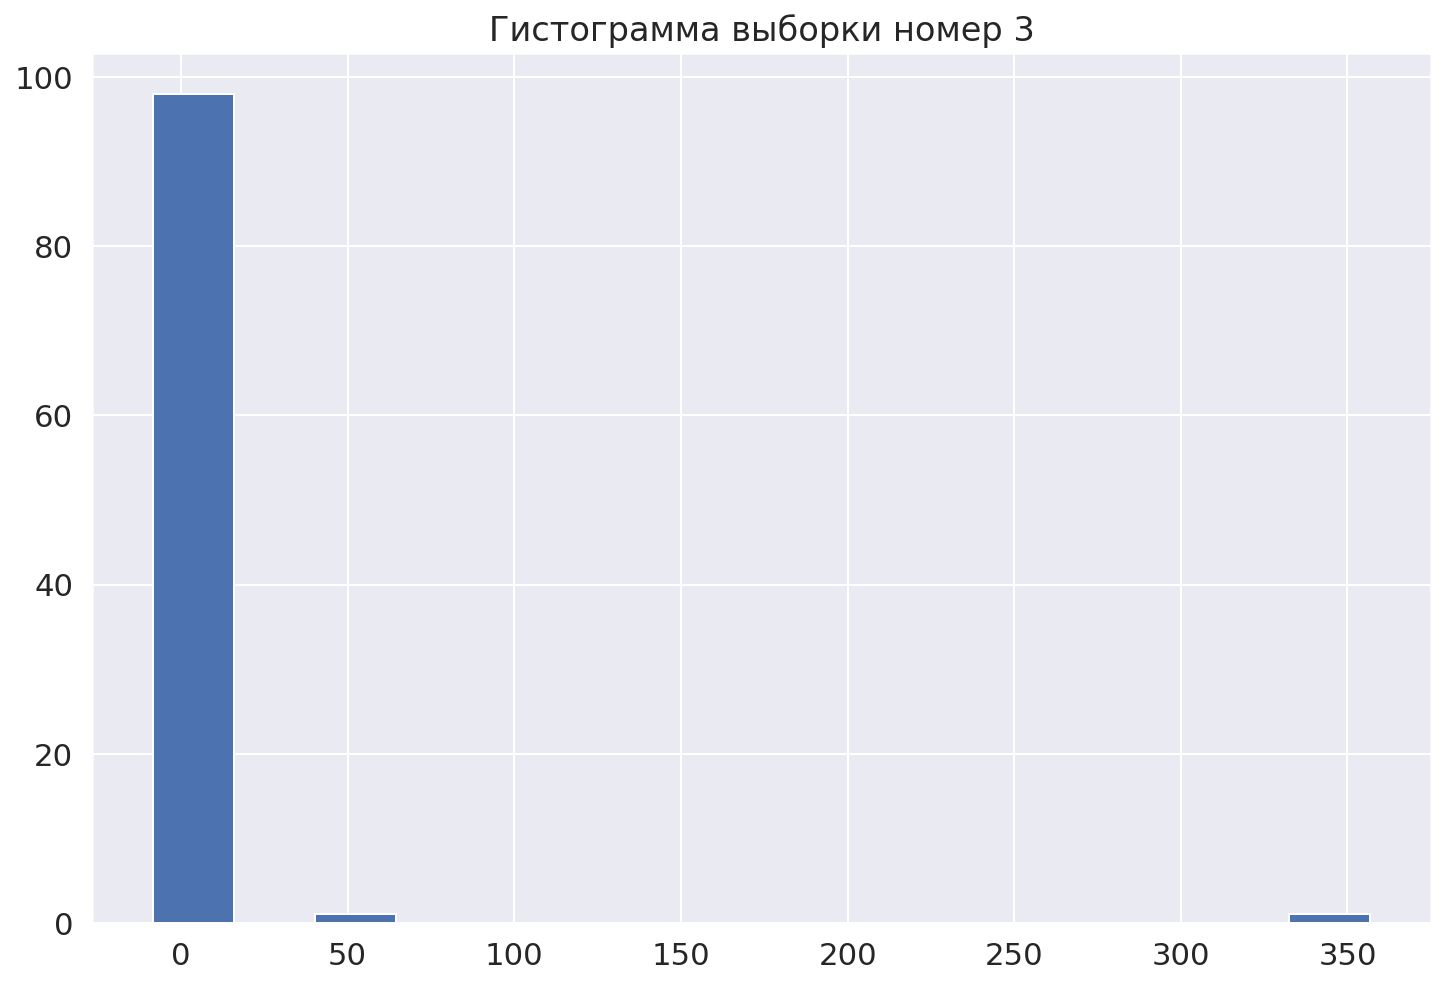

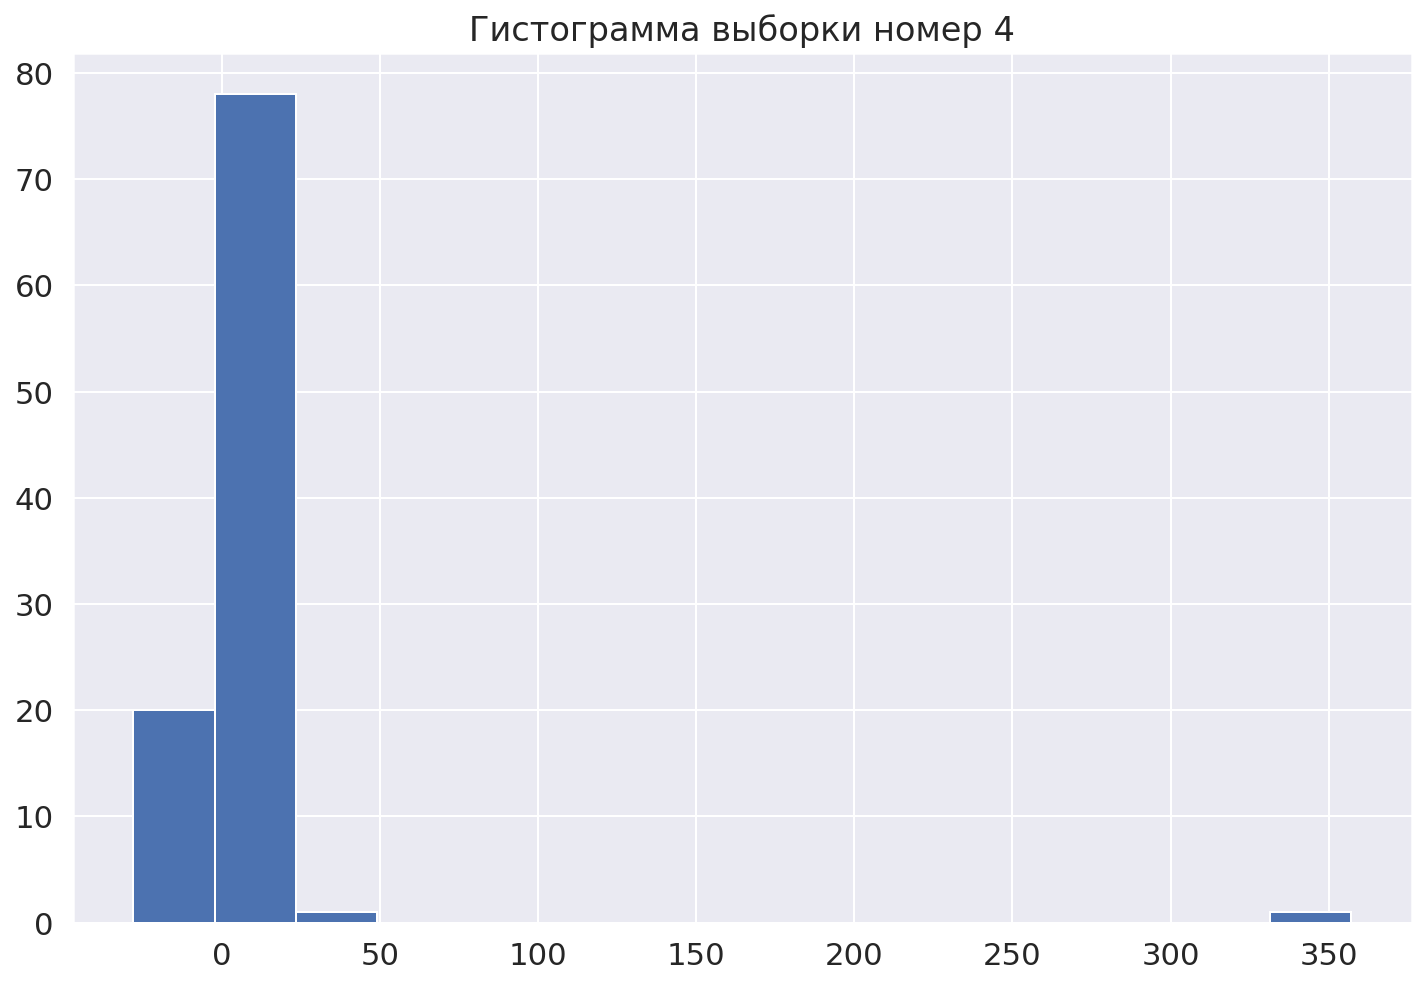

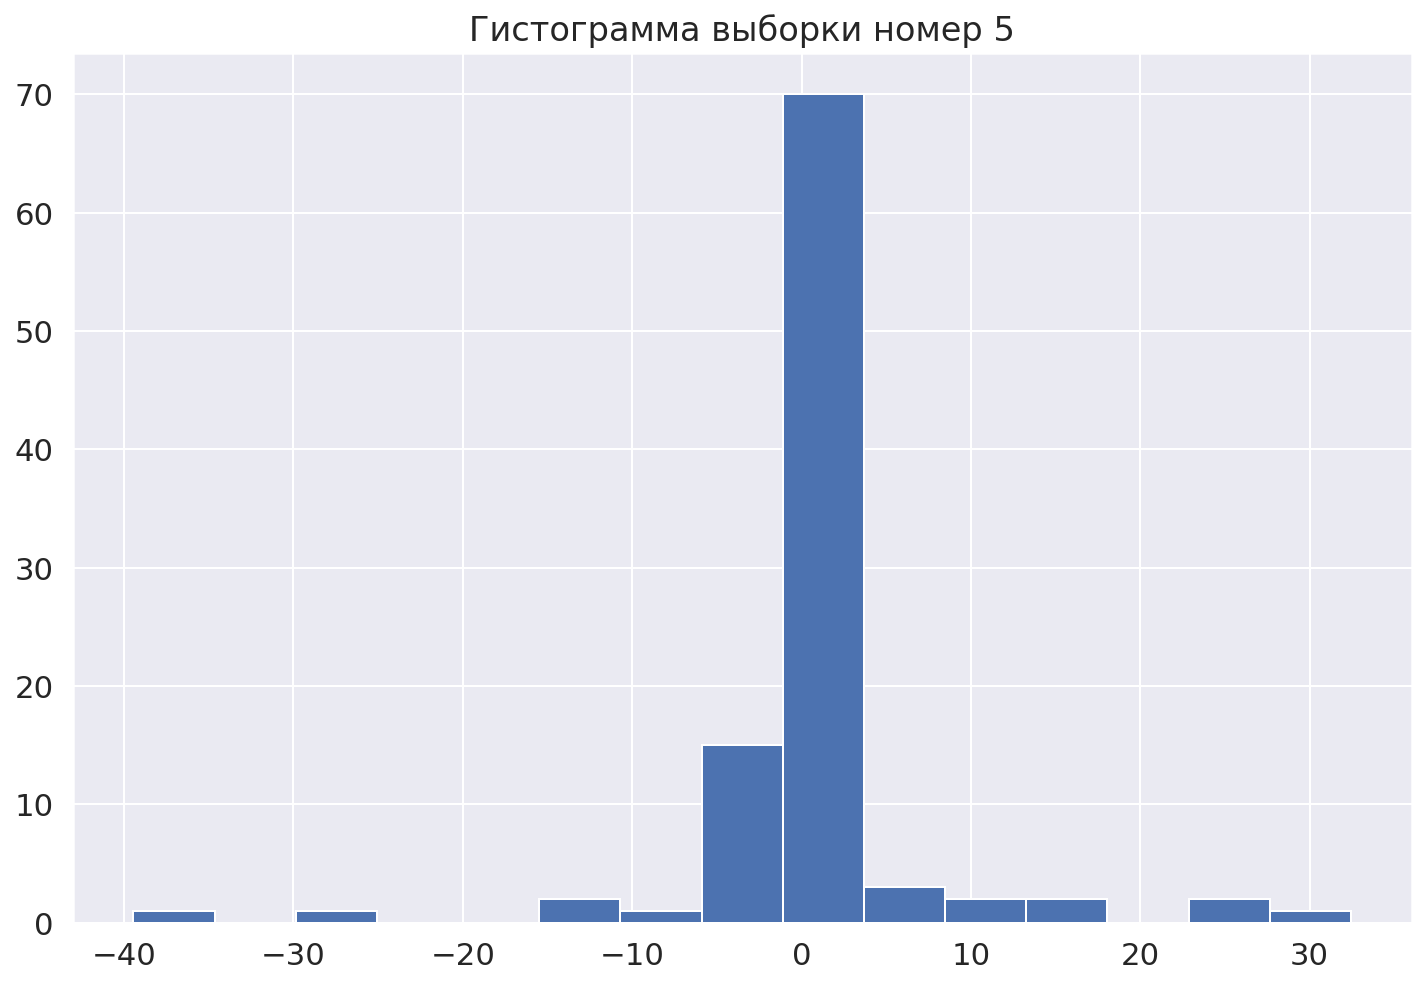

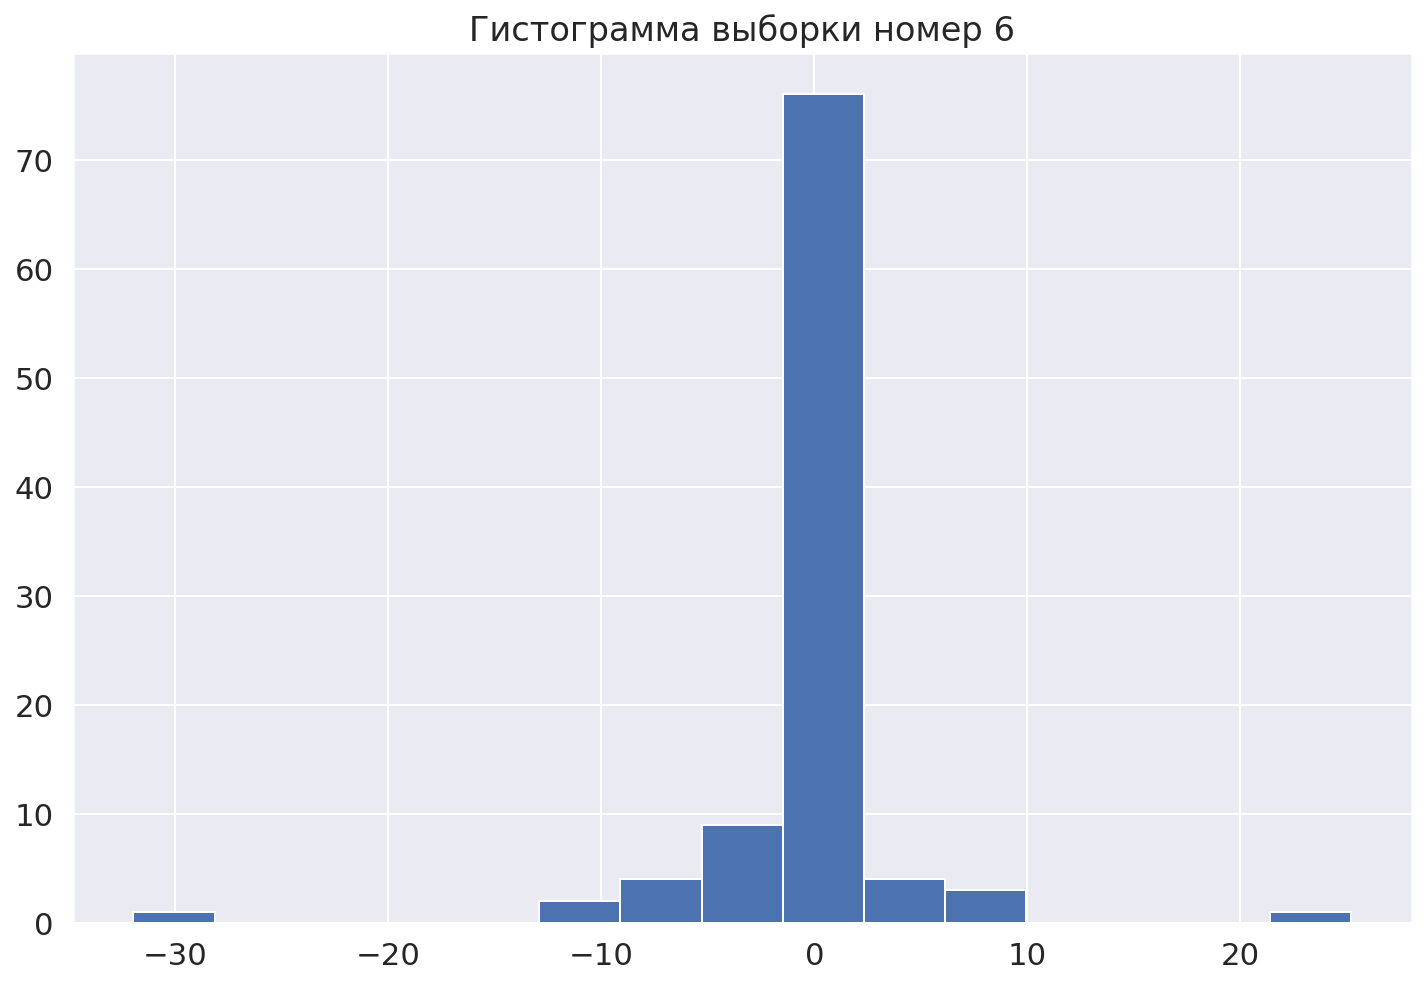

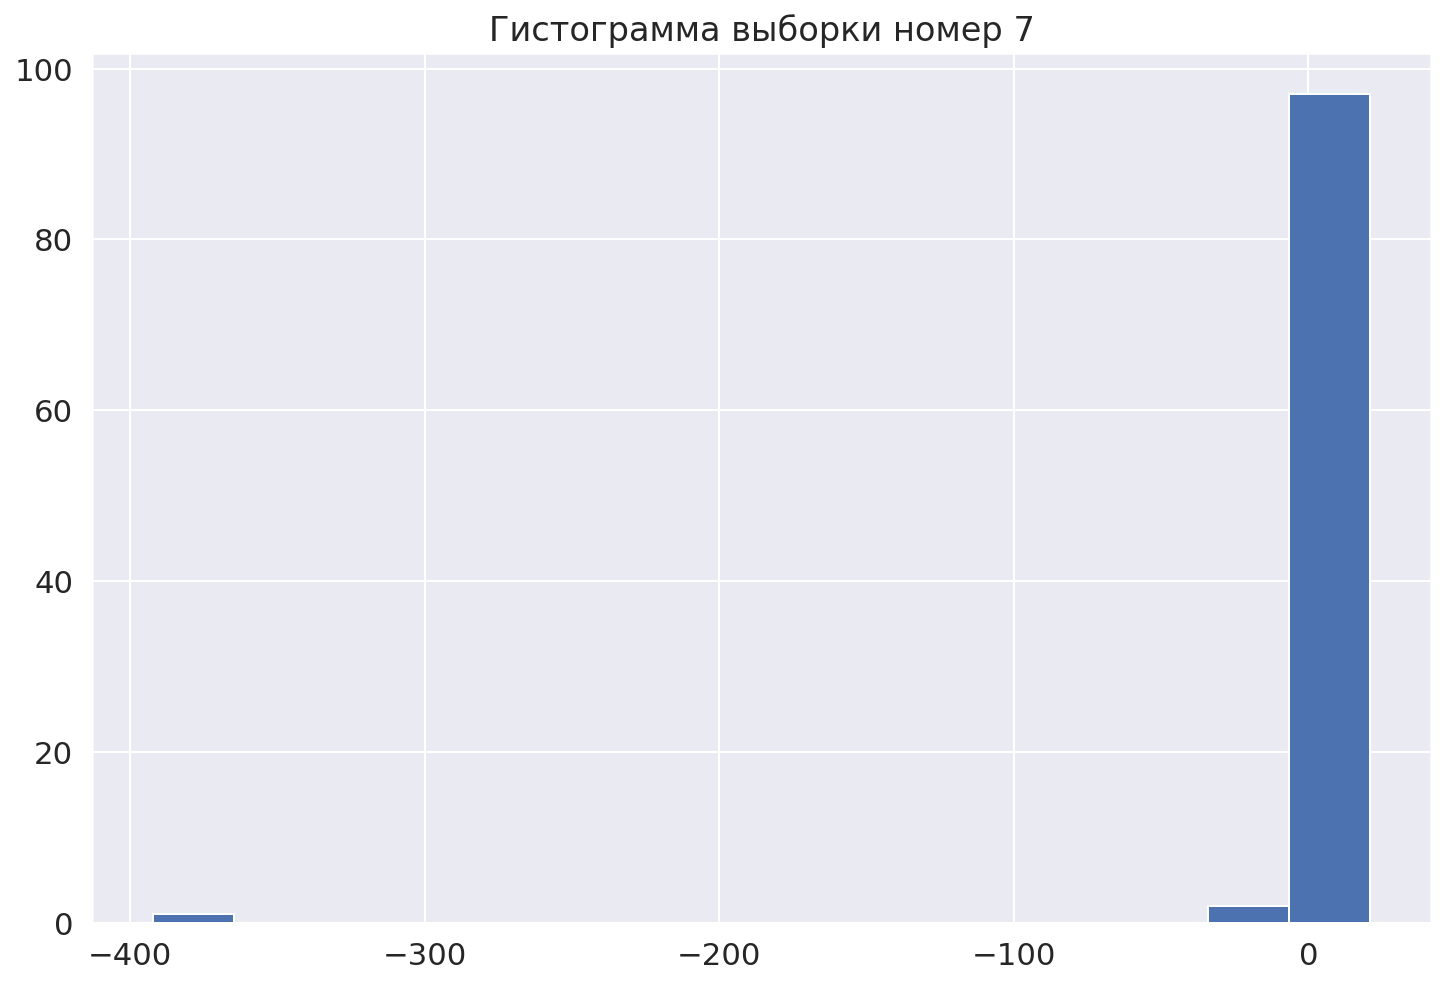

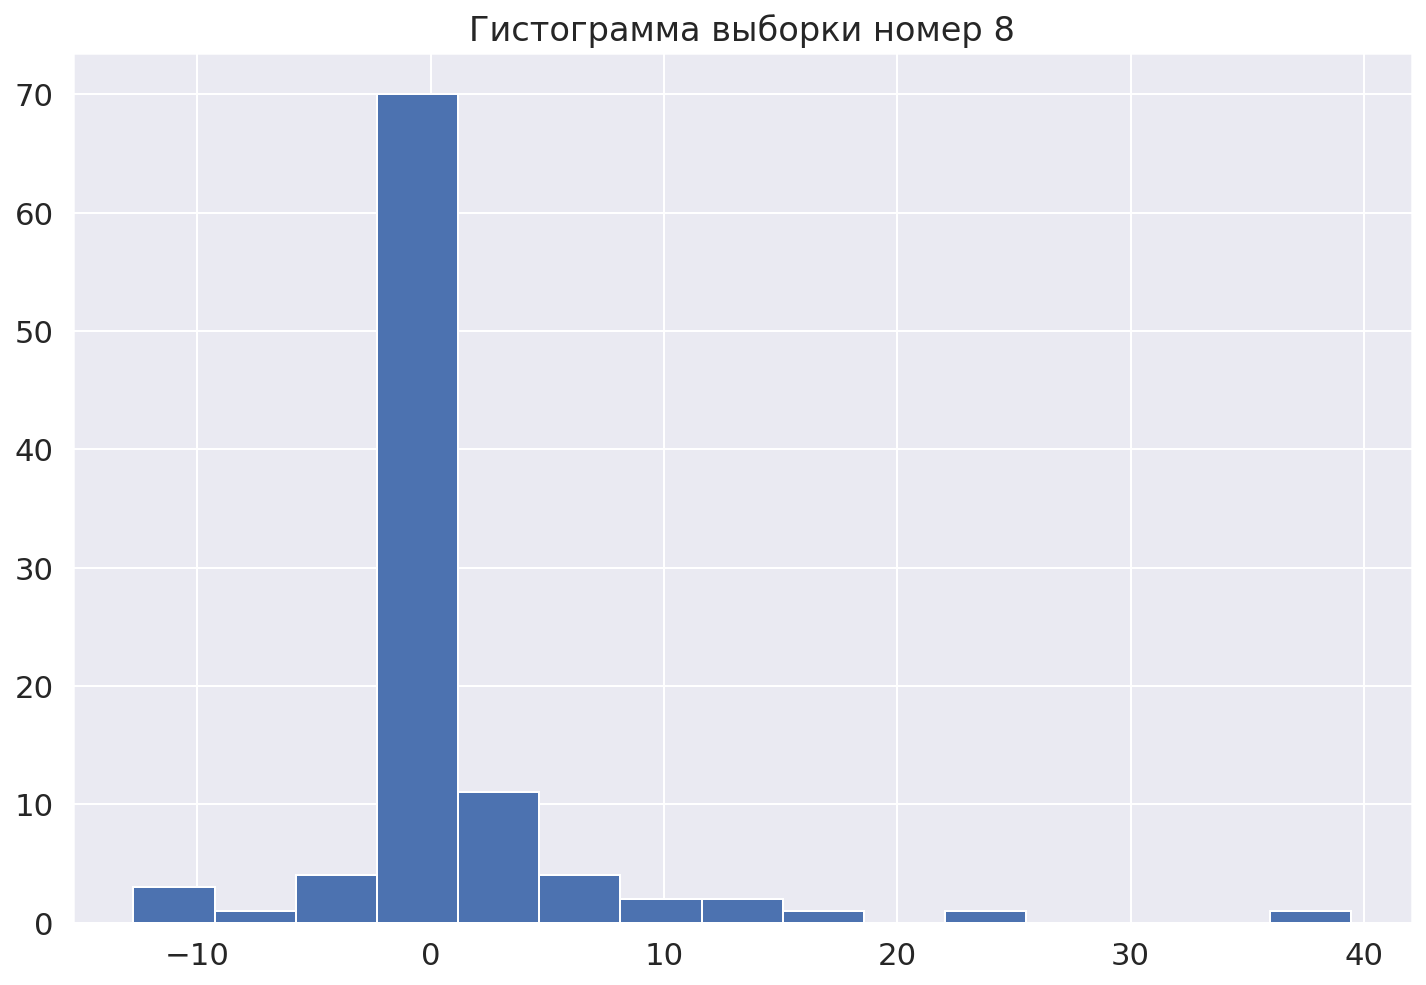

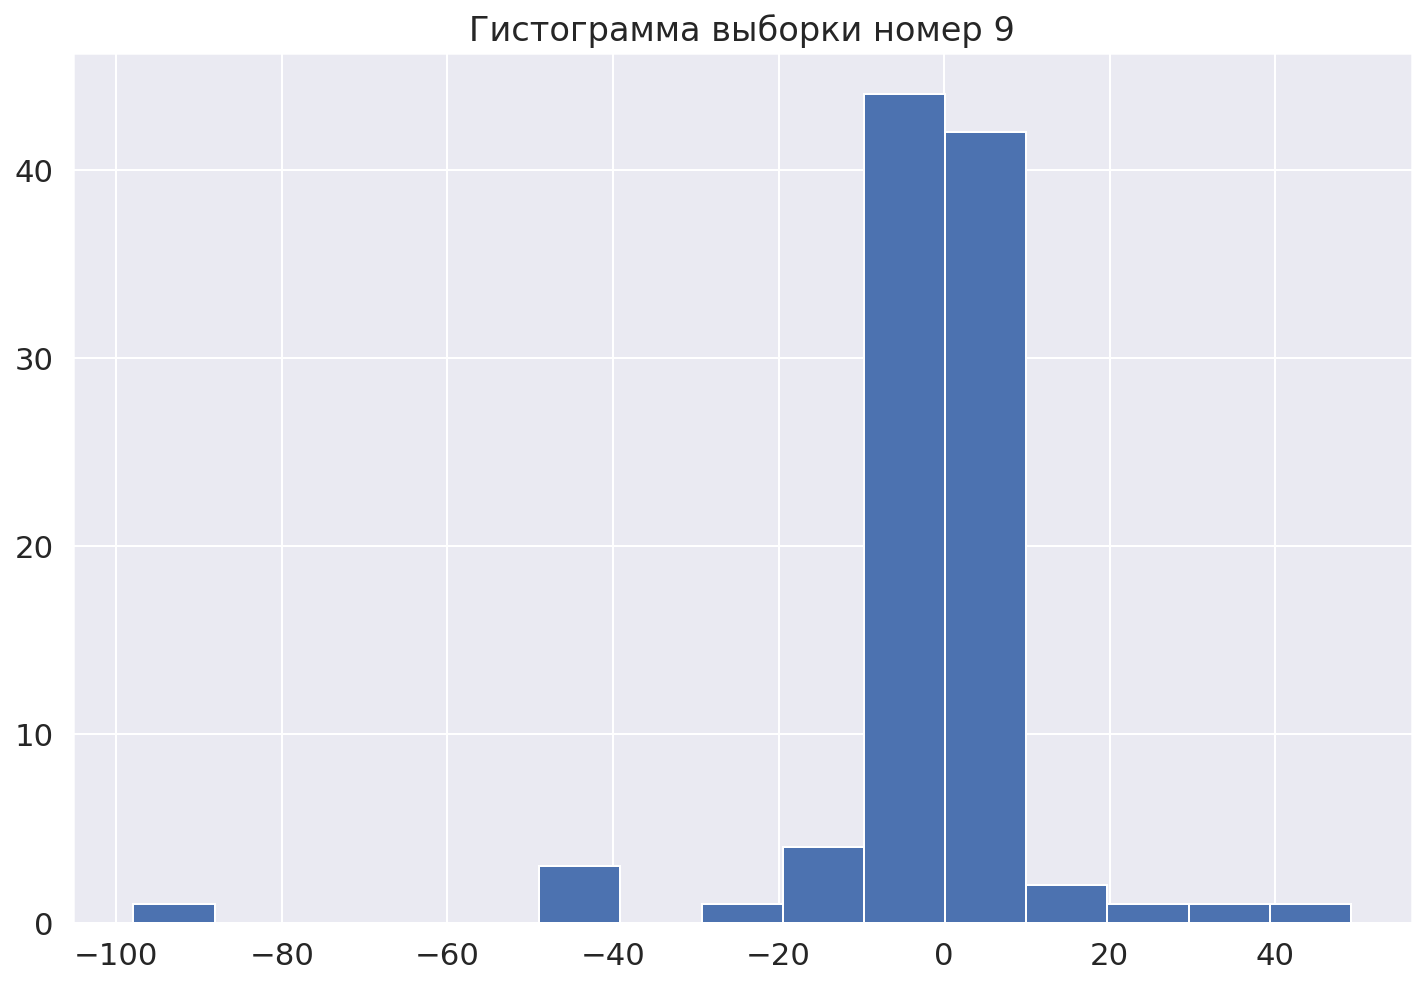

In [81]:
for ind, sample in enumerate(data):
    plt.figure(figsize =(12, 8))
    plt.hist(sample, bins = 15)
    plt.title(f"Гистограмма выборки номер {ind}")
    plt.show()

В условии задачи просят проделать множественную проверку гипотез. Но для начала проверим выборки на независимость в совокупности с помощью коэффициента конкордации. Напишем его вручную.

In [92]:
def calc_concordation(data):
    ranks = data.argsort().argsort()
    stat = np.sum(np.power(ranks.sum(axis = 0) - data.shape[0] * ( data.shape[1] + 1) / 2, 2))
    return (12 / (np.power(data.shape[0], 2) *(np.power(data.shape[1], 3) - data.shape[1]))) * stat   

In [93]:
calc_concordation(data)

0.19506222622262226

Пусть W-- полученная статистика. Исходя из лекции  $k(n - 1)W$ приближается хи-квадрат распределением с  $n- 1$ степенью свободы при $n > 10$, а в нашем случае $n = 100$.Тогда, критерий следующий:

$$
 k(n-1)W < z_{\frac{\alpha}{2}} \text{ или } k(n-1)W > z_{1 - \frac{\alpha}{2}}
$$
где $z_{q}$ -- соответсвующие квантили распределения хи-квадрат с $n - 1$ степенью свободы. 

In [120]:
def check_concord_crit(data, al):
    W = calc_concordation(data) * data.shape[0] * (data.shape[1] - 1)
    z_1 = sps.chi2(data.shape[1] - 1).ppf(al / 2)
    z_2 = sps.chi2(data.shape[1] - 1).ppf(1 - al / 2)
    print(f"Значение статистики -- {W}")
    if W < z_1 or W > z_2:
        print(f"Гипотеза о независимости в совокупности на уровне {al} отвергается")
    else:
        print(f"Гипотеза о независимости в совокупности на уровне {al} не отвергается")

In [121]:
 check_concord_crit(data, al)

Значение статистики -- 514.0120481927711
Гипотеза о независимости в совокупности на уровне 0.05 отвергается


Теперь перейдем к попарной проверке независимости выборок с помощью процедуры множественной проверки гипотез.

Как видим, в данных есть выбросы. Поэтому нужно использовать коэффициент корреляции Спирмена или Кендалла. Мы воспользуемся  коэффициентом корреляции Спирмена. Проверять будем попарную независимость выборок с помощью множественной проверки гипотез.  Если хотя бы одна гипотеза о попарной независимости отвергнется, то, соответсвенно, есть смысл отвергать гипотезу о независимости в совокупности. Для контроля FWER будем использовать метод Холма, так как независимости в статистиках, которые используются в критериях, у нас не будет.

In [101]:
batch = []
p_vals = []
for i in range(data.shape[0]):
    for j in range(i):
        p_vals.append( sps.spearmanr(data[i], data[j])[1])
        batch.append({'first': i, 'second' : j, 'pval' : p_vals[-1]})
        

In [102]:
batch

[{'first': 1, 'second': 0, 'pval': 0.4124011821849358},
 {'first': 2, 'second': 0, 'pval': 0.5283761423456816},
 {'first': 2, 'second': 1, 'pval': 0.9524681488567421},
 {'first': 3, 'second': 0, 'pval': 0.012588622848083814},
 {'first': 3, 'second': 1, 'pval': 0.6602068583646066},
 {'first': 3, 'second': 2, 'pval': 0.046276667236984925},
 {'first': 4, 'second': 0, 'pval': 0.9159082031485144},
 {'first': 4, 'second': 1, 'pval': 0.9693726190431702},
 {'first': 4, 'second': 2, 'pval': 0.40503633925329274},
 {'first': 4, 'second': 3, 'pval': 0.1768629925814752},
 {'first': 5, 'second': 0, 'pval': 0.30820670238771253},
 {'first': 5, 'second': 1, 'pval': 0.6582307154944229},
 {'first': 5, 'second': 2, 'pval': 0.4316745726594654},
 {'first': 5, 'second': 3, 'pval': 0.5151659341267478},
 {'first': 5, 'second': 4, 'pval': 0.2778308330608518},
 {'first': 6, 'second': 0, 'pval': 0.6680483040729859},
 {'first': 6, 'second': 1, 'pval': 0.1892653909188385},
 {'first': 6, 'second': 2, 'pval': 0.08534

In [103]:
ans_lib = multipletests(np.array(p_vals), alpha = 0.05, method = "holm")[0]
for hypo, ans in zip(batch, ans_lib):
    if ans:
        print(f"На уровне значимости {al} гипотеза о независимости отвергается для выборок под номерами {hypo['first']} и {hypo['second']}")

На уровне значимости 0.05 гипотеза о независимости отвергается для выборок под номерами 8 и 1


Таким образом, гипотеза о независимости в совокупности отвергается. 

Посмотрим на выборки, для которых мы отвергли гипотезу о независимости.

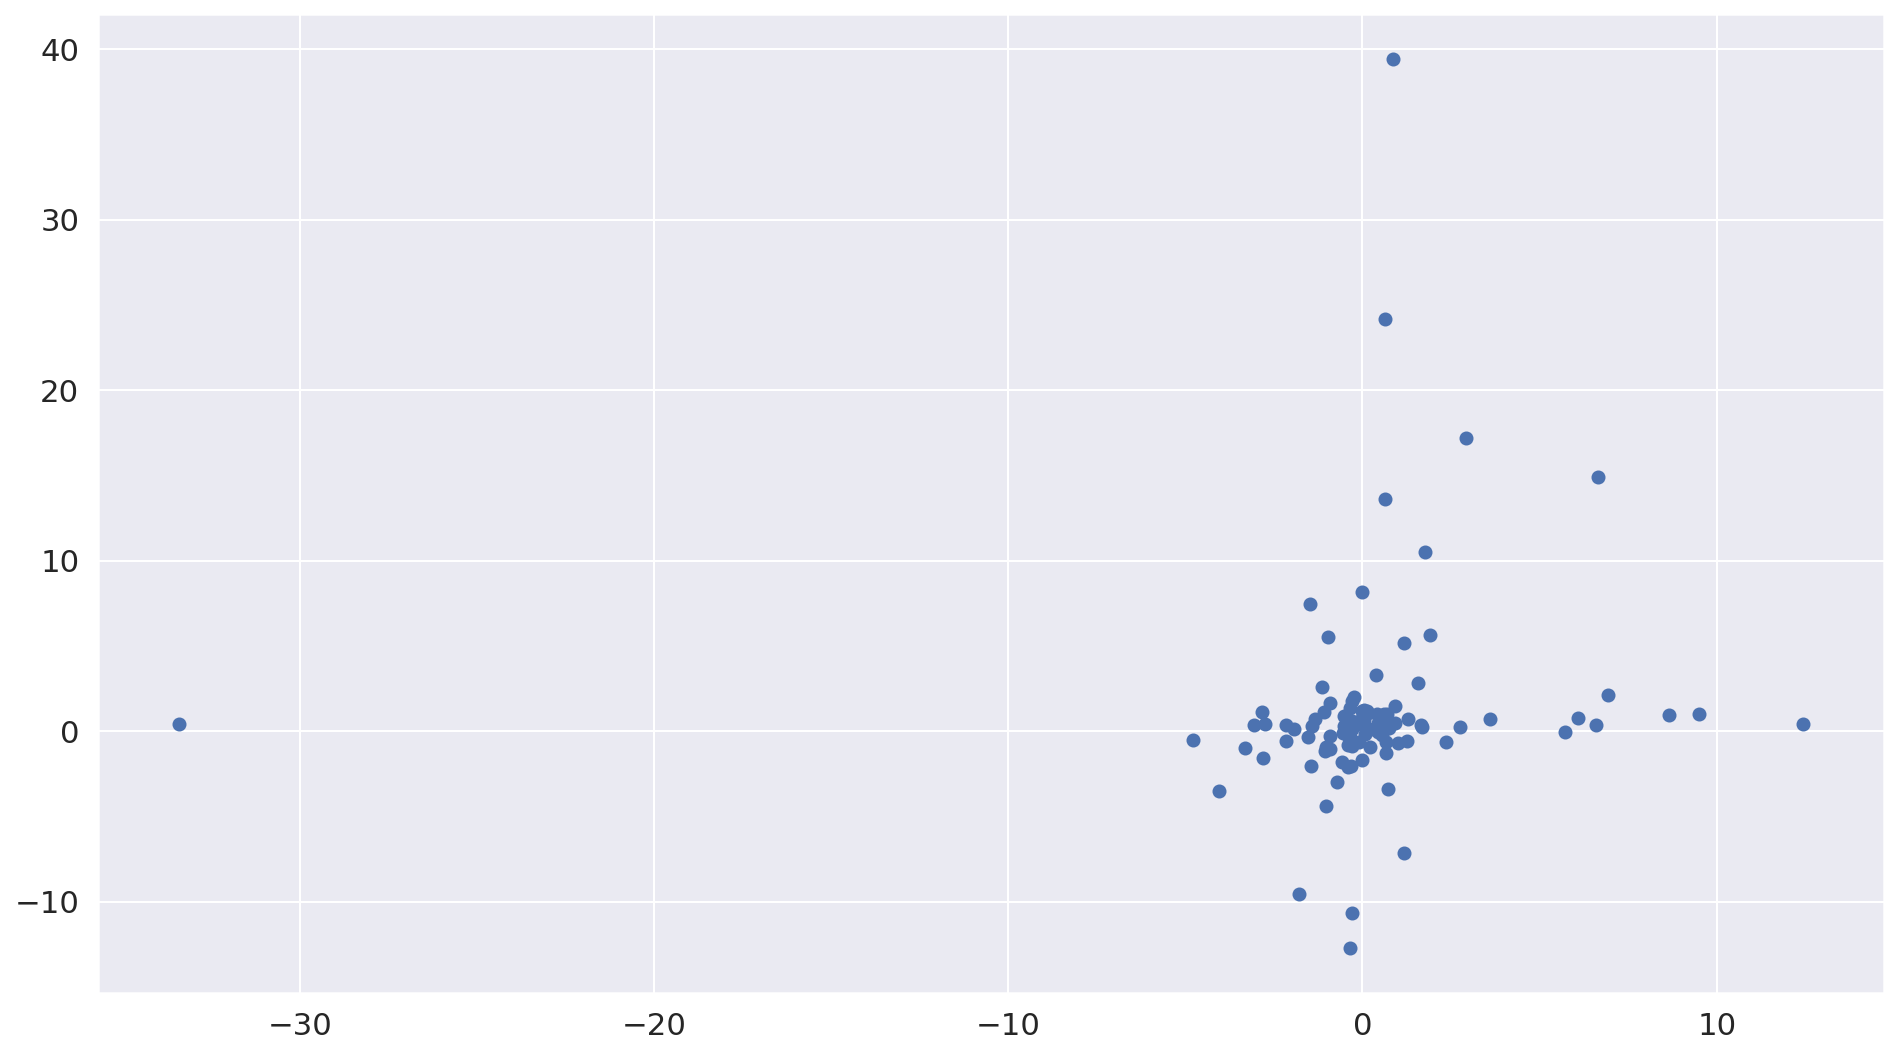

In [104]:
plt.figure(figsize = (16, 9))
plt.scatter(data[1], data[8])
plt.show()

Теперь чуть ближе к основному набору точек.

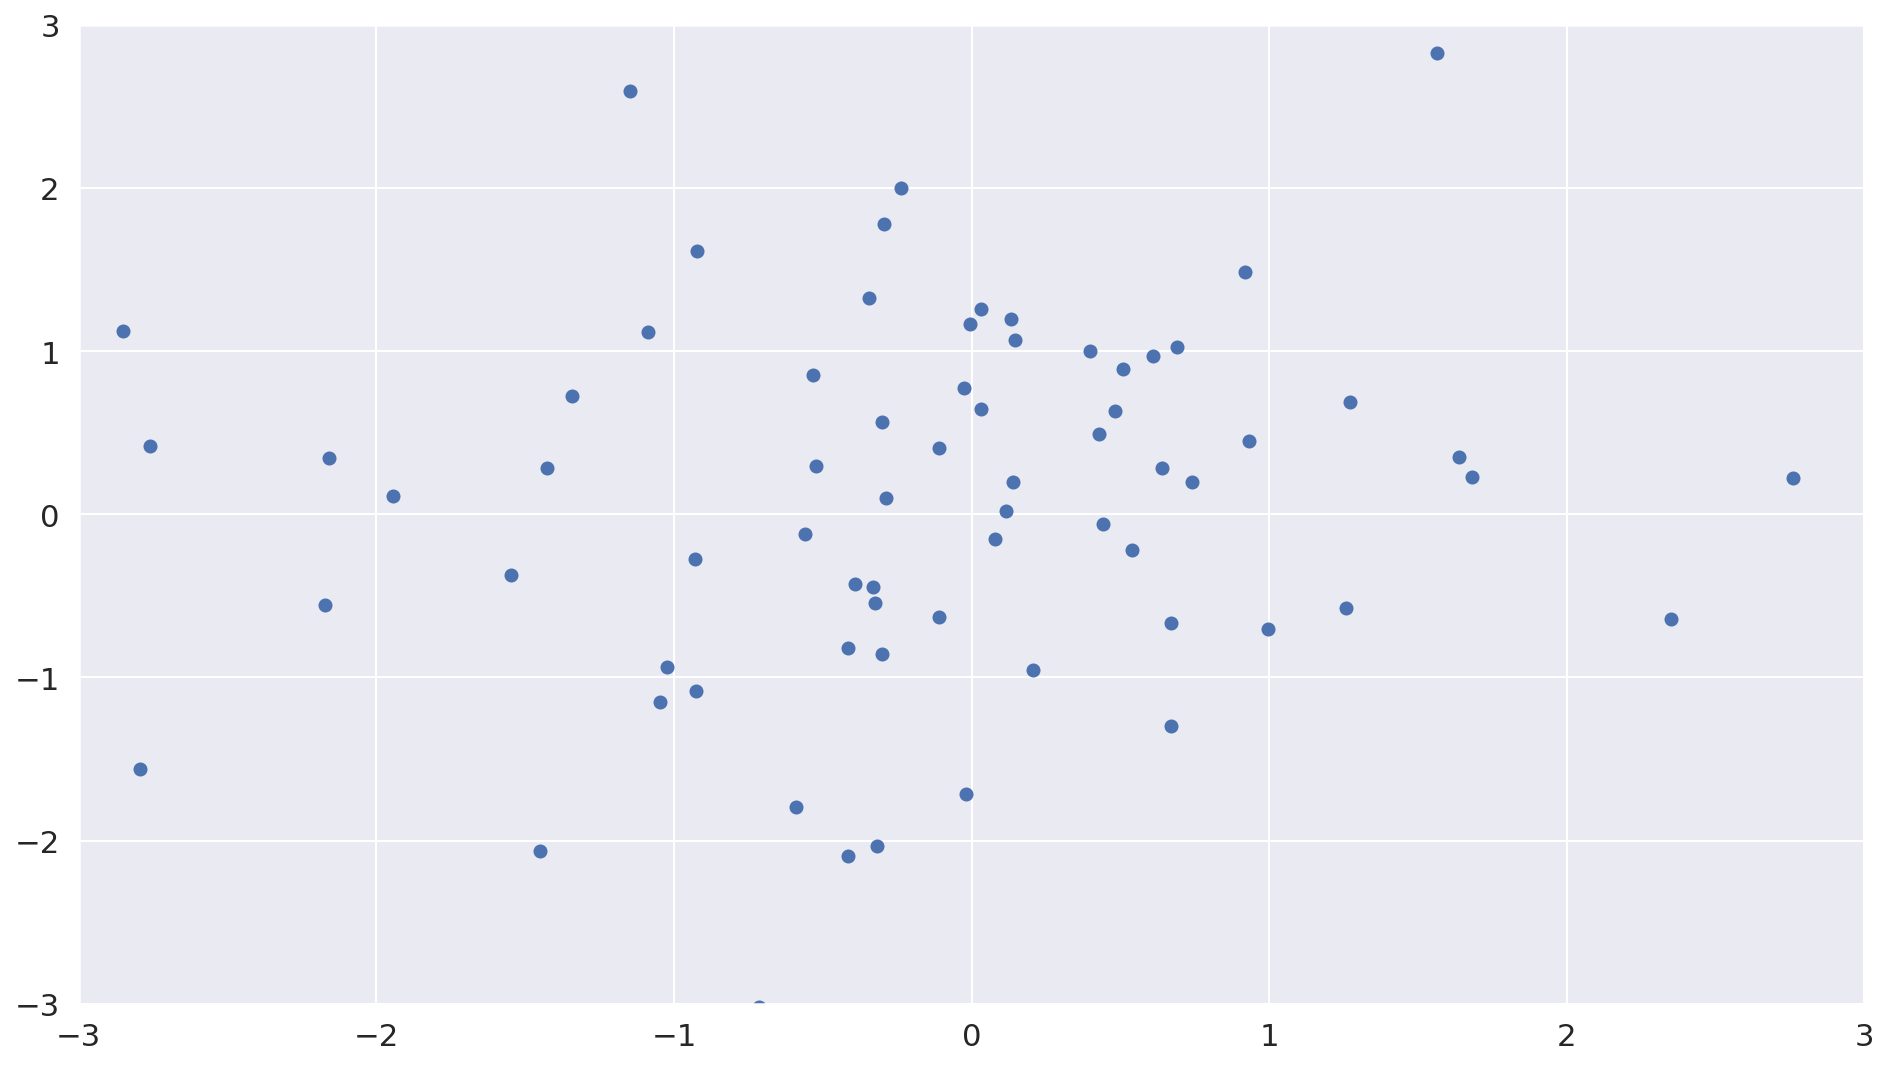

In [105]:
plt.figure(figsize = (16, 9))
plt.scatter(data[1], data[8])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

Глазами не сильно видно, есть ли какая-либо завиcимость. Первое, что бросается в глаза -- каждый из четырех углов почти пустой (по два прямоугольника). Если выборки независимы, обычно мы наблюдаем побольше элементов в углах.

### Задача 5

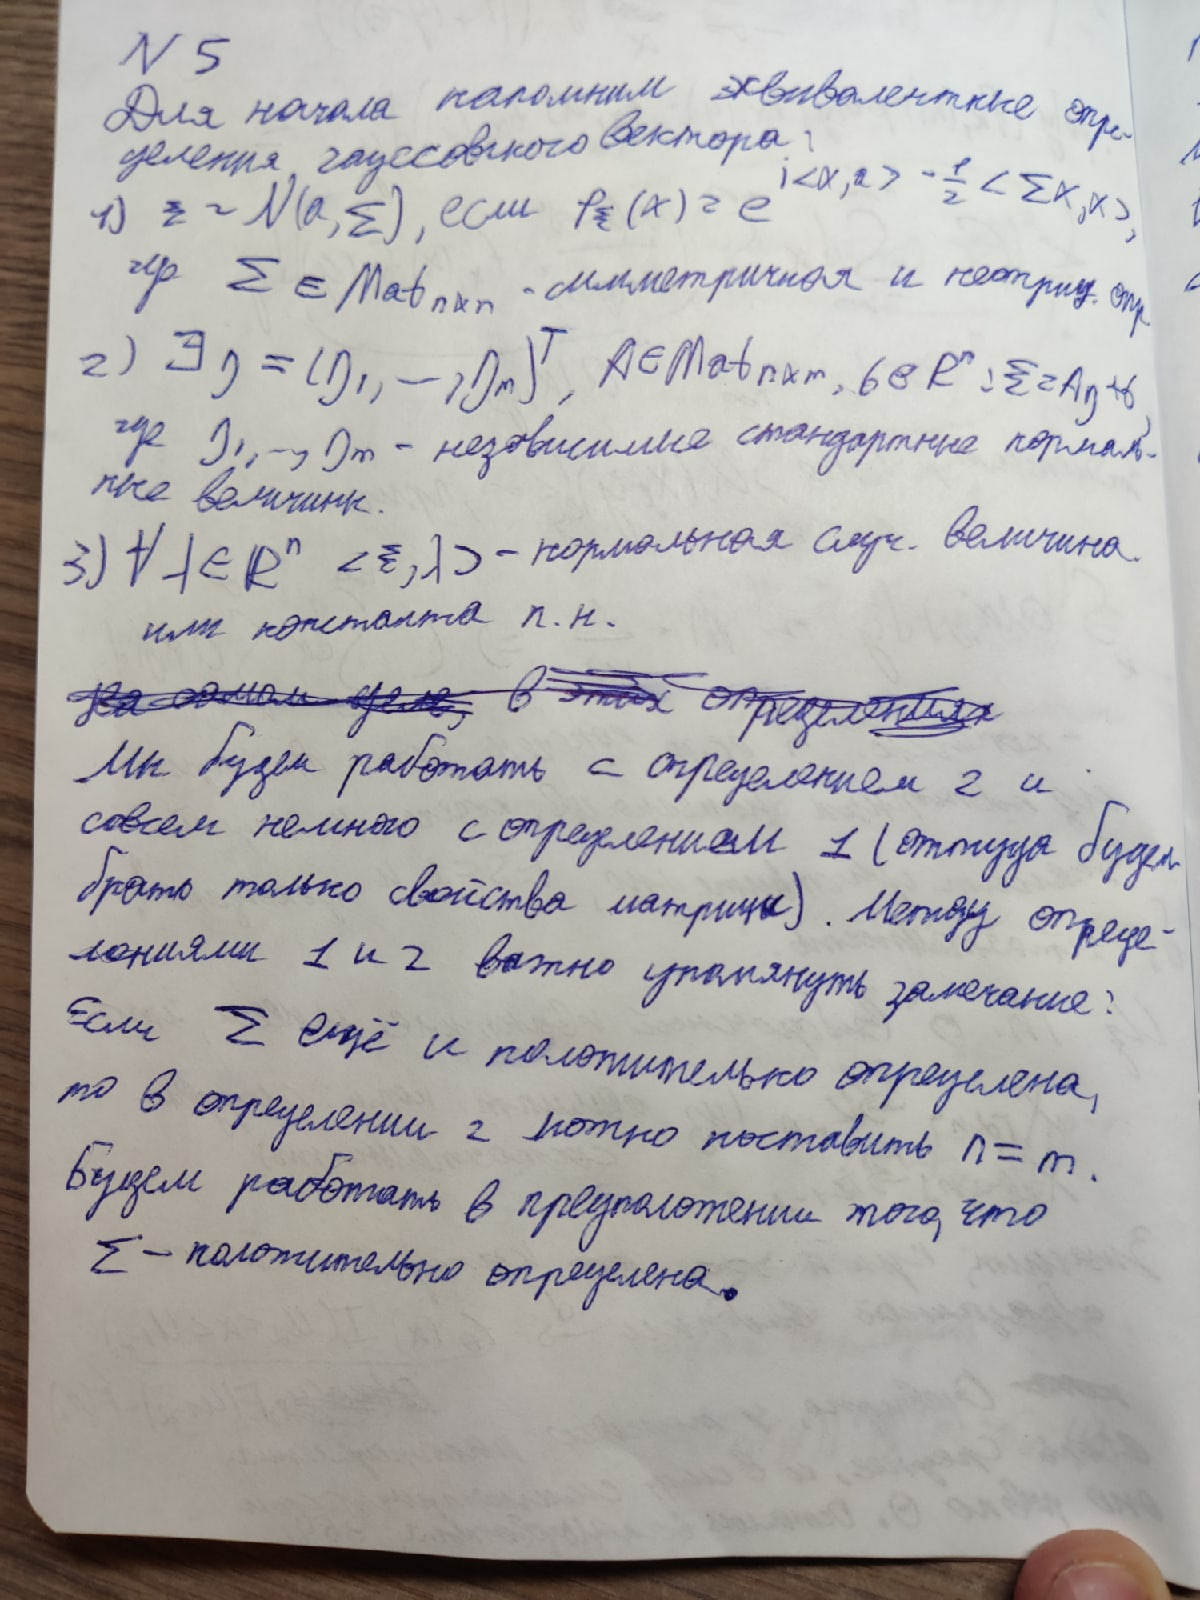

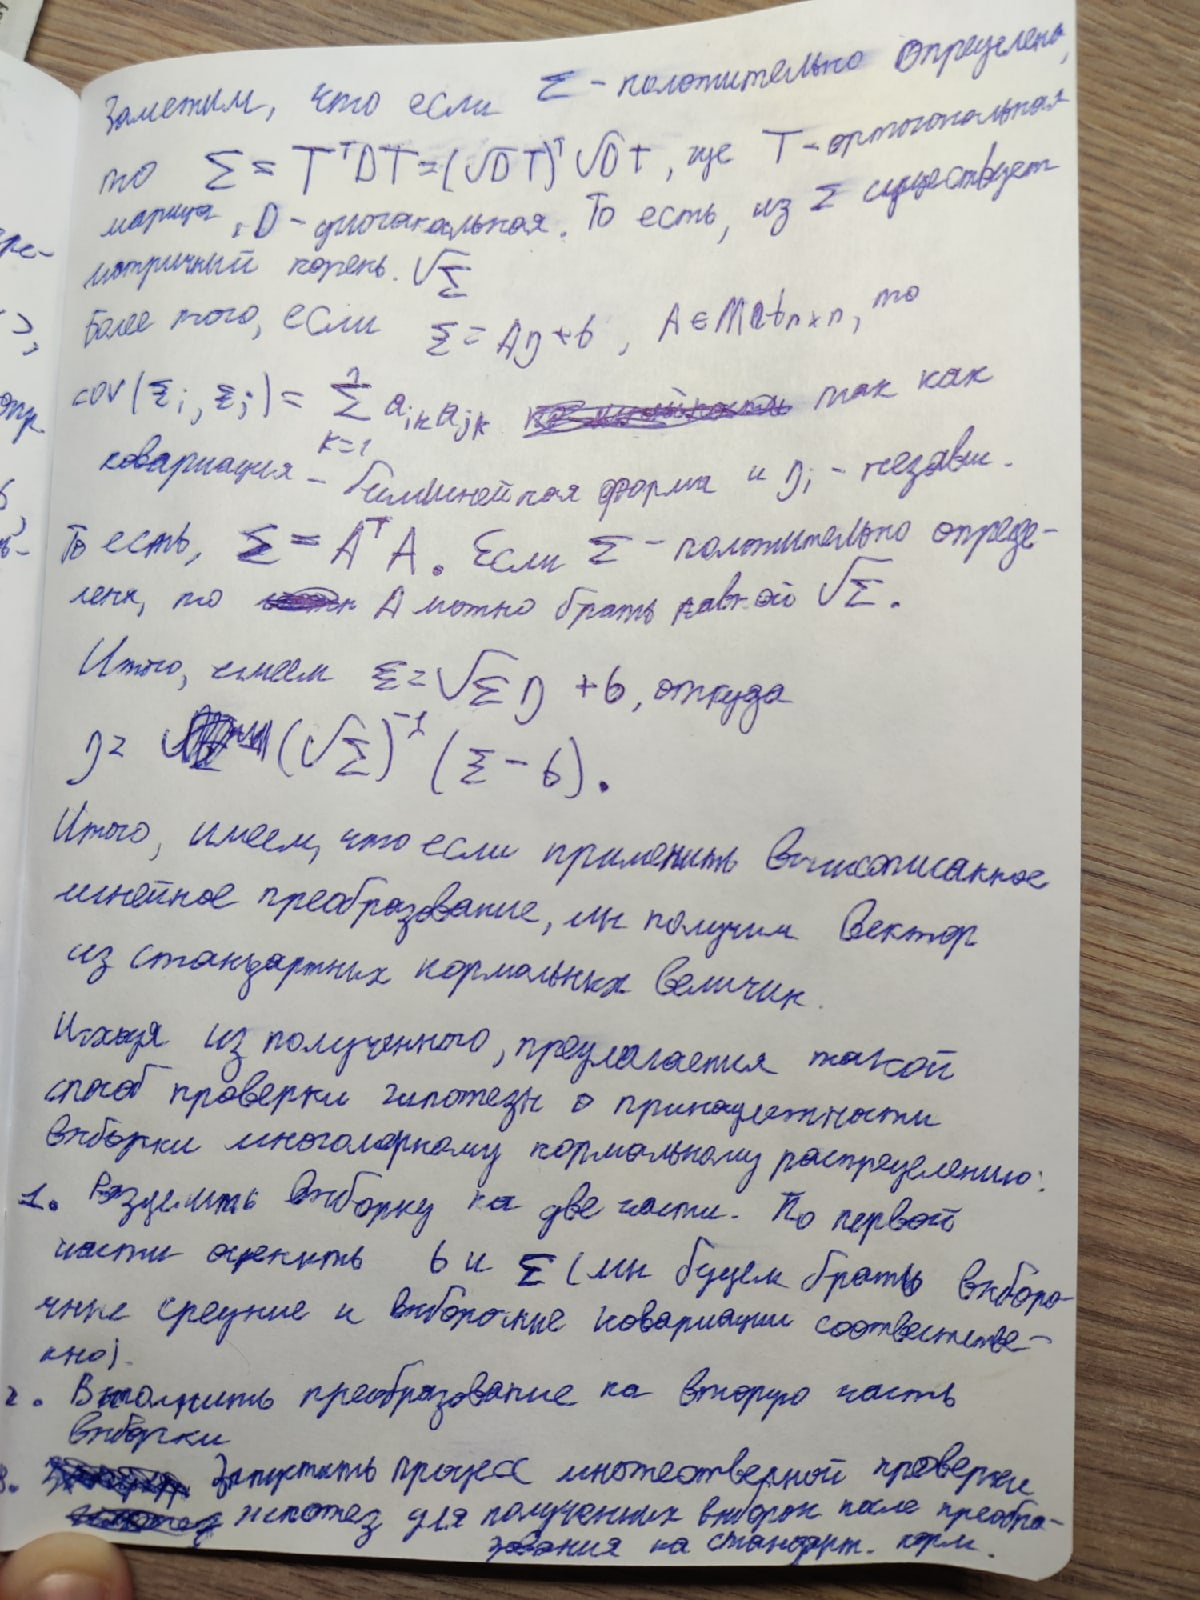

**Замечание:** В процесс множественной проверки гипотез также нужно включить проверку на независимость в совокупности. 

Считаем данные, посмотрим на размерность данных.

In [106]:
data = np.load("hw5t5.npy")

In [107]:
data.shape

(4, 200)

Имеем размерность вектора, равную 4. Надо как-то проверить наличие выбросов. Можно попробовать покоординатно, например.

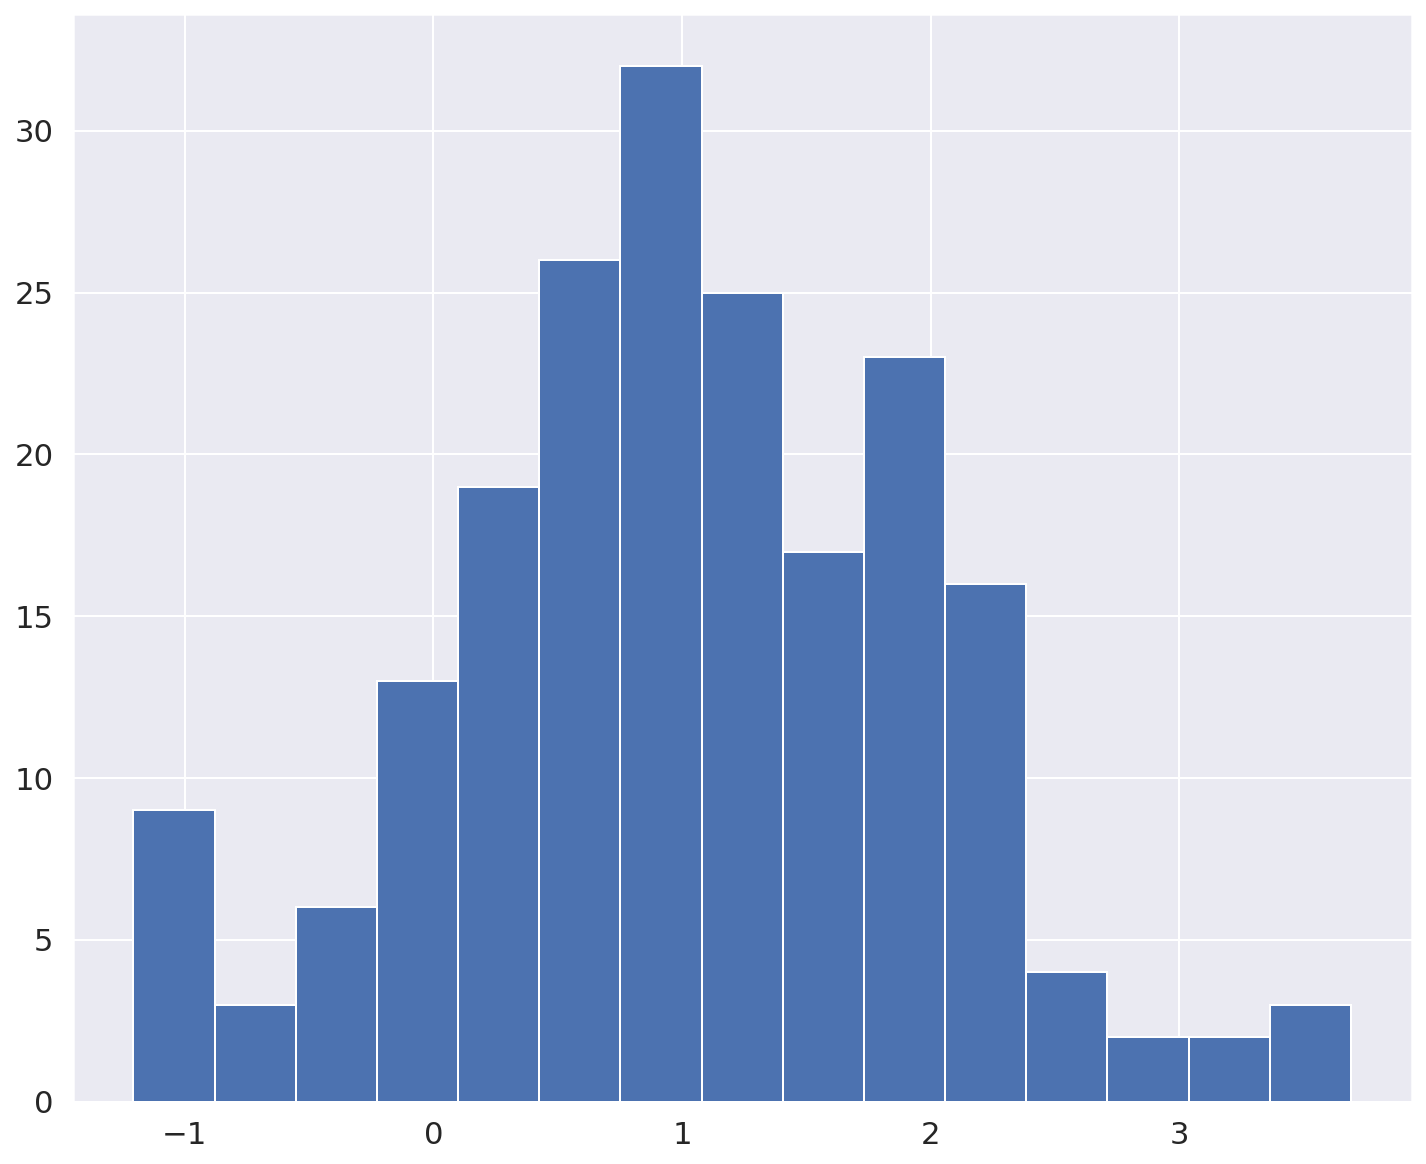

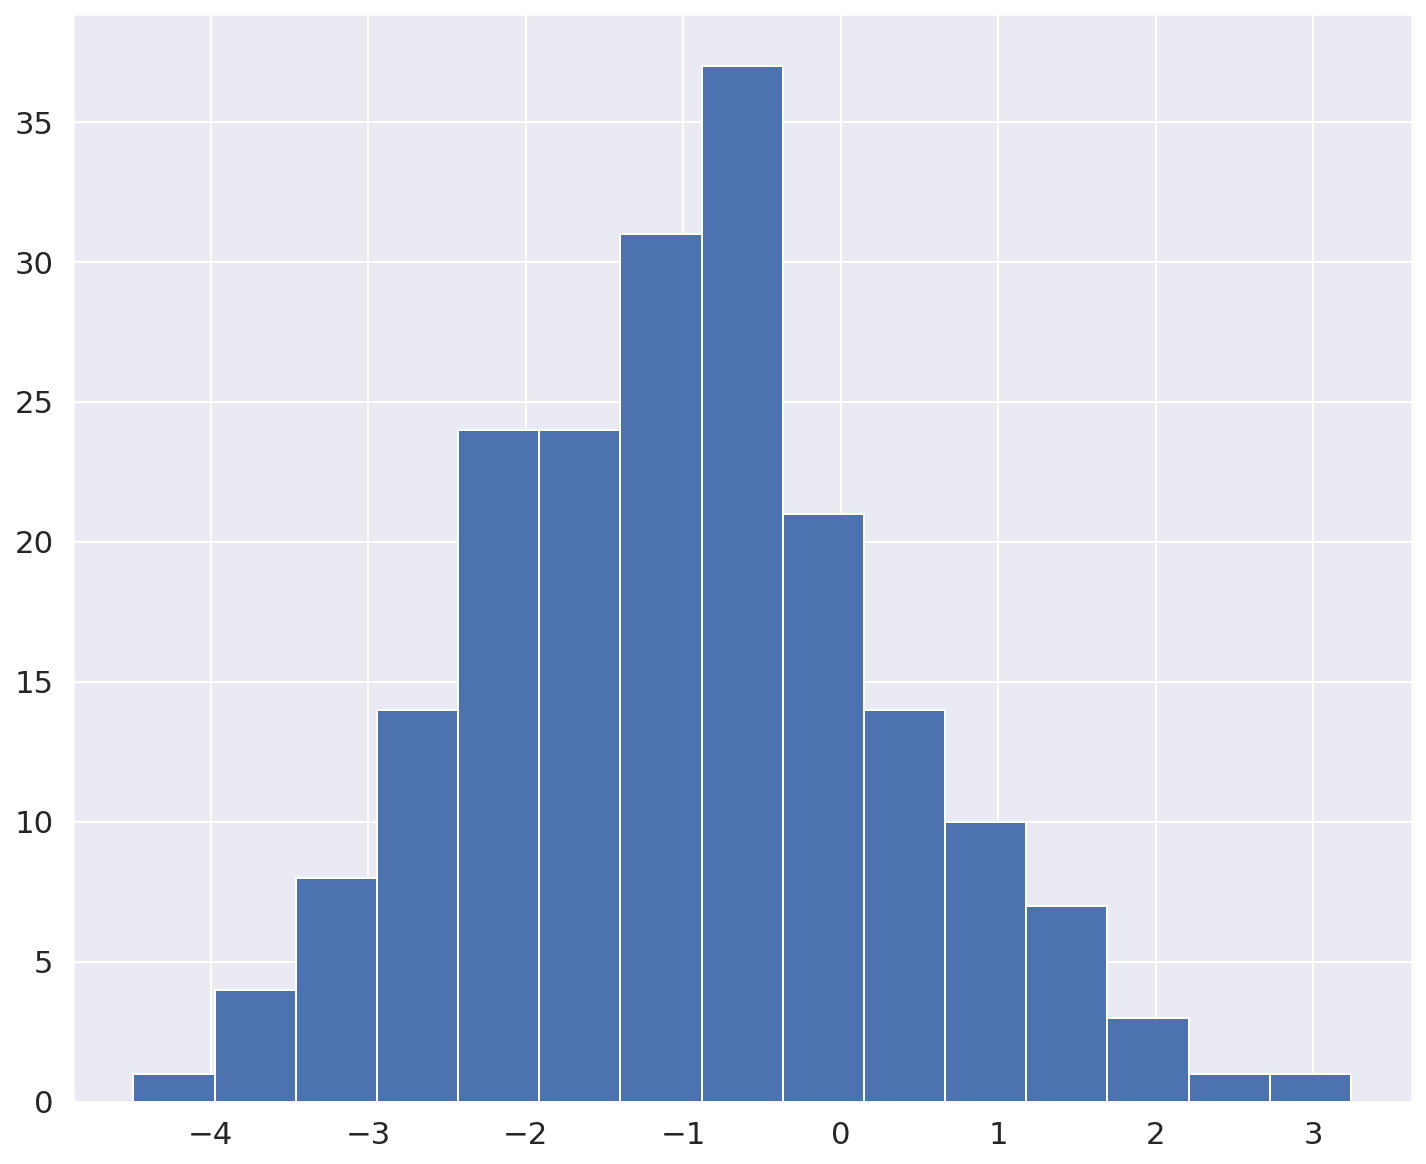

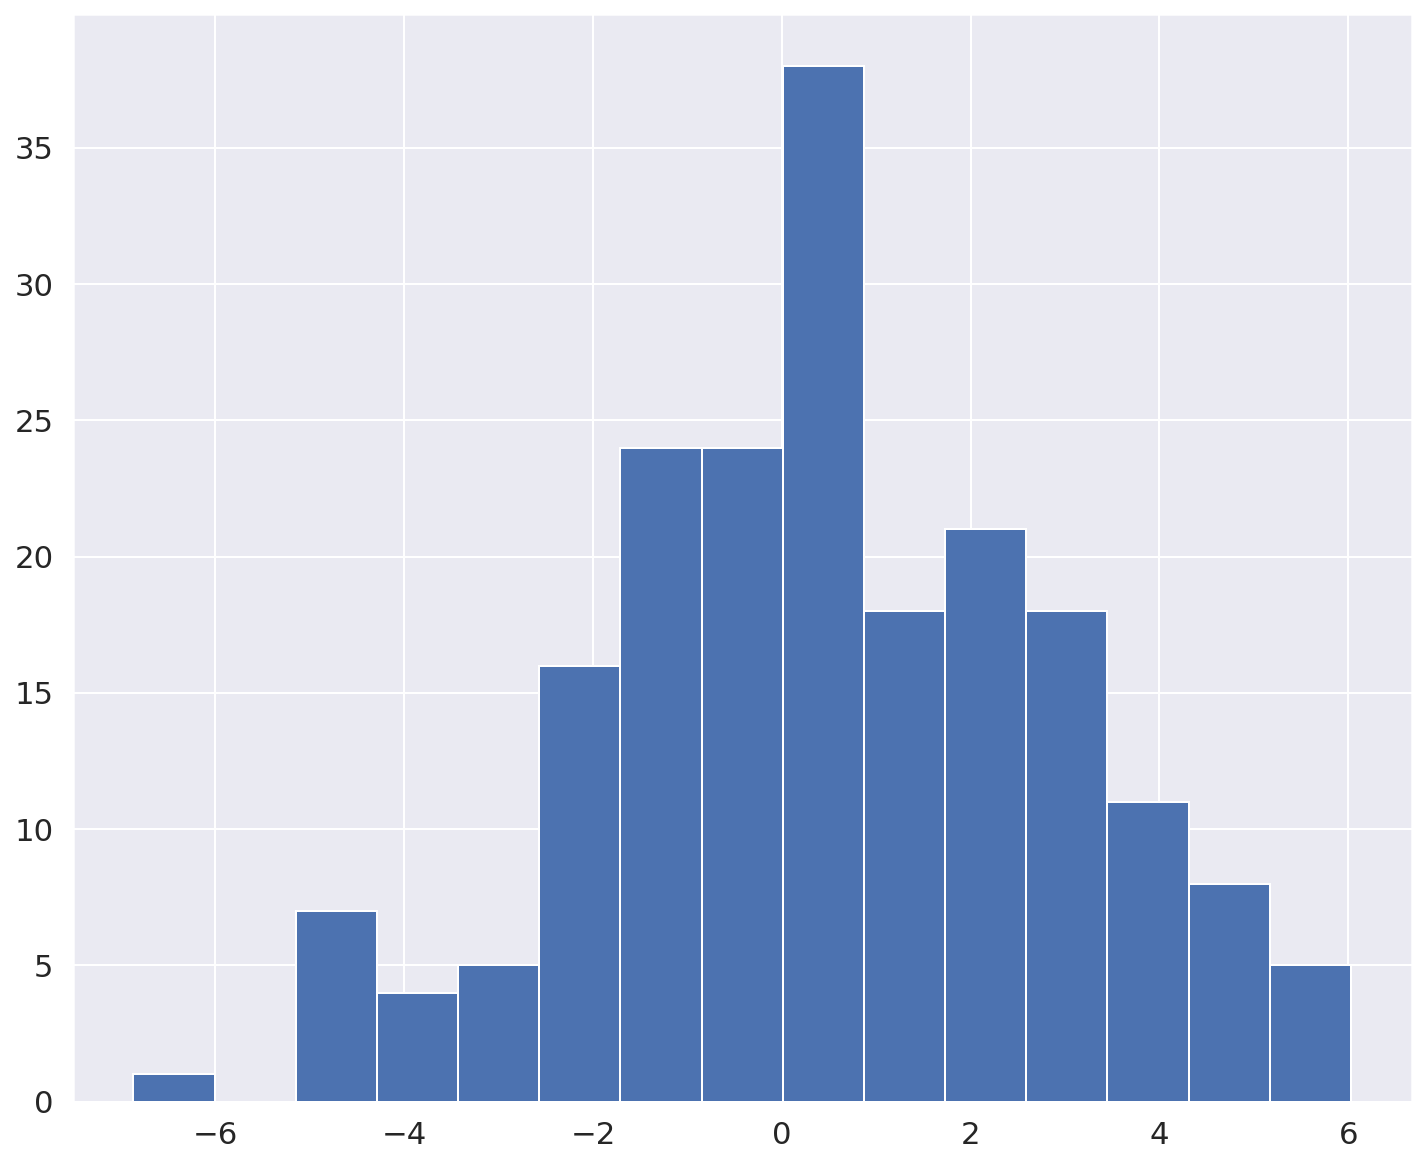

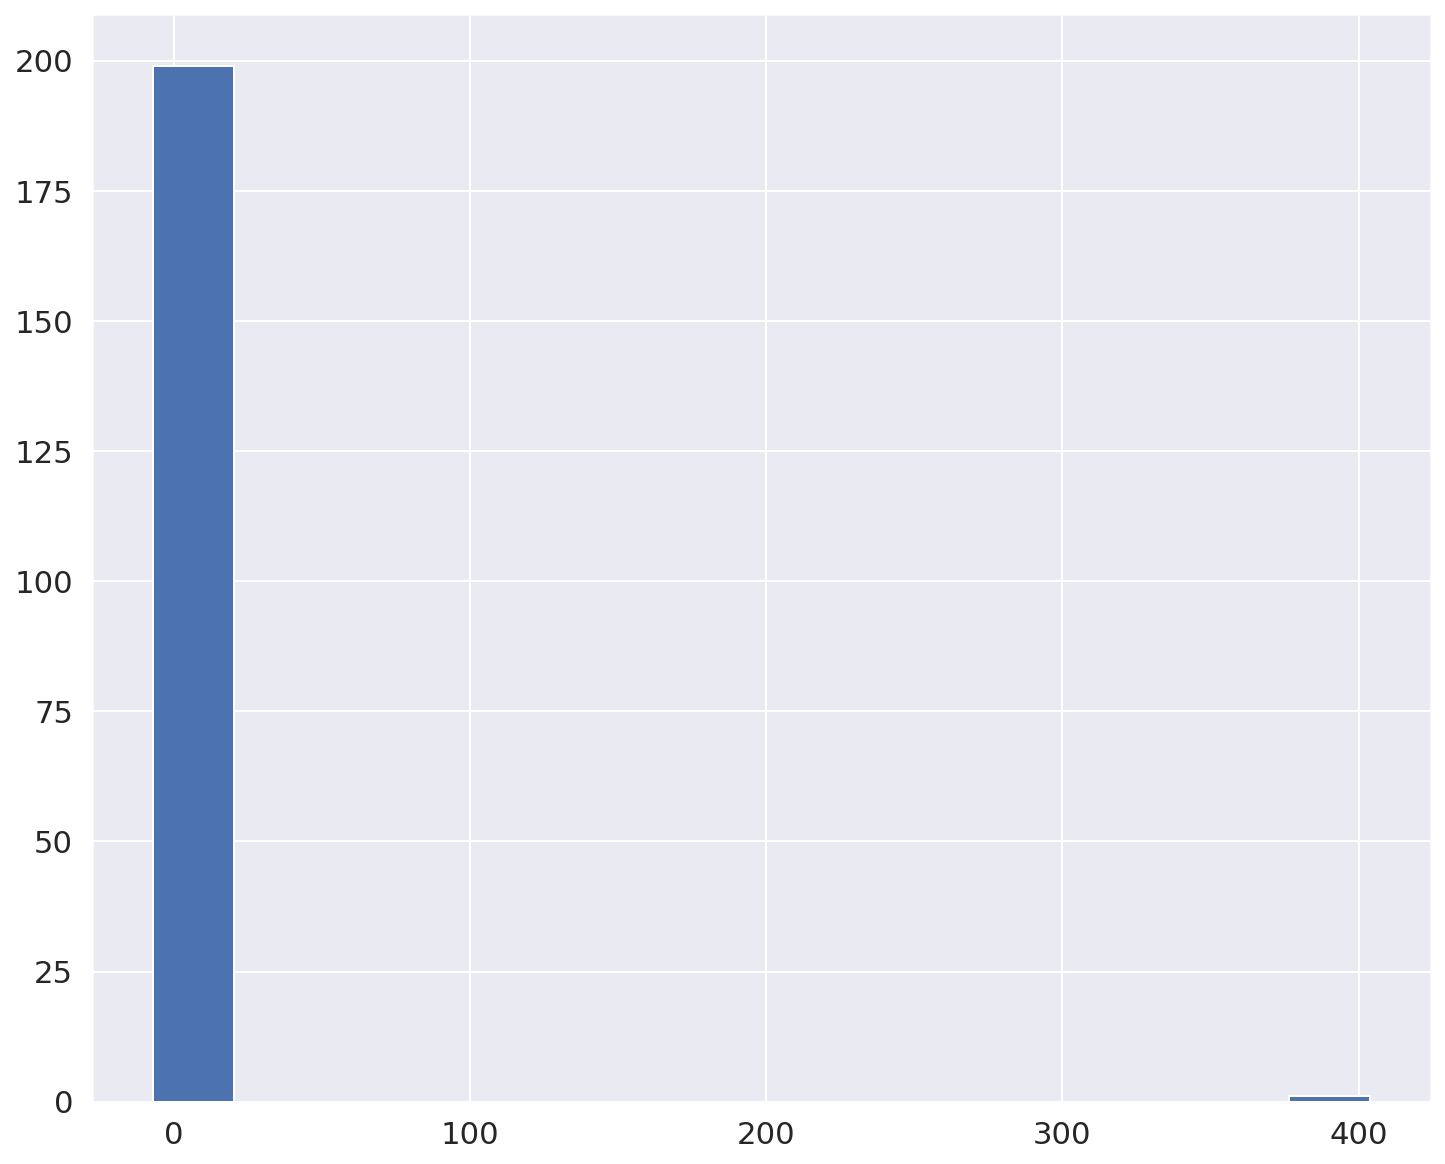

In [108]:
for cord in data:
    plt.figure(figsize = (12, 10))
    plt.hist(cord, bins = 15)
    plt.show()

Видно, что по последней координате есть очень большие значения (около 400), когда все остальные -- в районе нуля. Значит, видимо выбросы есть. Для их детектирования воспользуемся IsolationForest. Перед этим транспонируем данные, чтобы он мог работать.

In [109]:
data = data.T

In [110]:
clf = IsolationForest(random_state = 5)
clf.fit(data)
y = clf.predict(data)
data = data[y == 1]
data.shape

(166, 4)

In [111]:
train, test = data[:data.shape[0] // 2, :], data[data.shape[0] // 2: , :]
train.shape, test.shape

((83, 4), (83, 4))

In [112]:
from scipy.linalg import sqrtm
from scipy.linalg import inv

cov = np.cov(train.T)
print(np.linalg.det(cov))

1.4591043412544977


In [113]:
cov_root = sqrtm(cov)

Определитель достаточно хорошо отделен от нуля, а значит все рассуждения, приведенные выше, можно применять в данном случае.

In [114]:
mean_vec = np.mean(train, axis = 0)
mean_vec

array([ 1.07016096, -1.0596245 ,  0.62037394, -0.37768039])

Для того, чтобы автоматически сработал broadcasting придется немного пошаманить с транспонированием. В конце, мы просто сверим, что размерности остались нужными.

In [115]:
modified_test = inv(cov_root) @ (test - mean_vec).T
modified_test.shape

(4, 83)

Данные транспонировались, но это даже к лучшему, по ним будет проще итерироваться. Взглянем на распределение выборок, что мы получили после преобразования. 

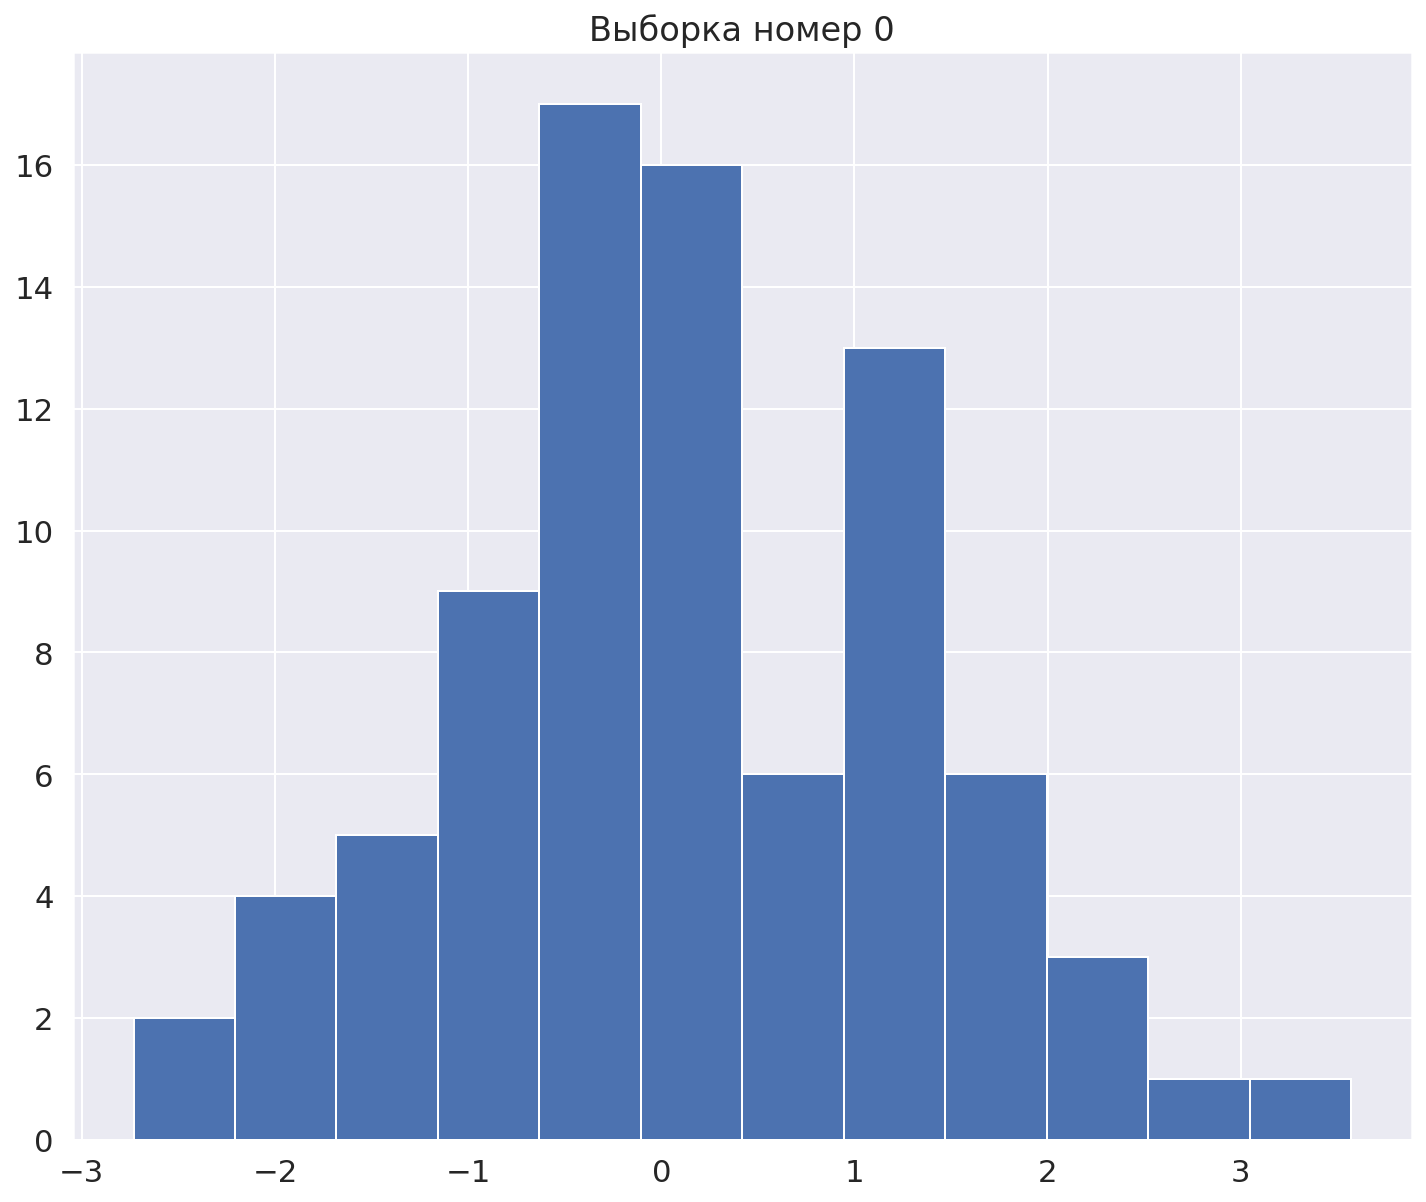

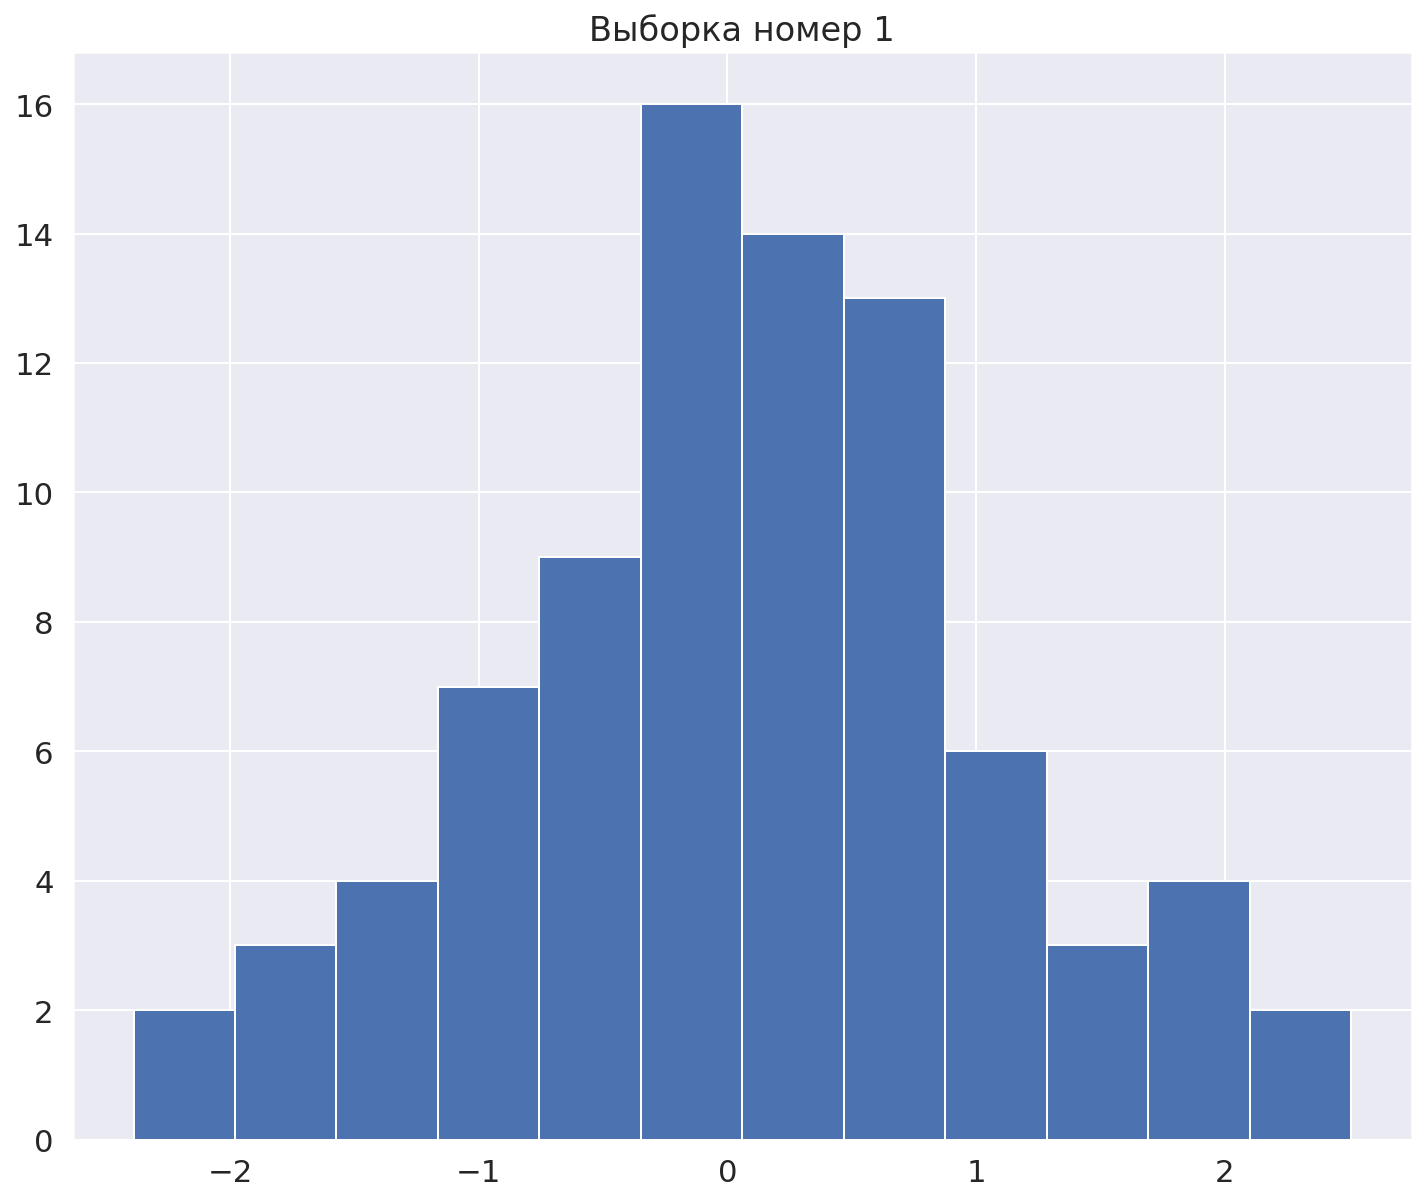

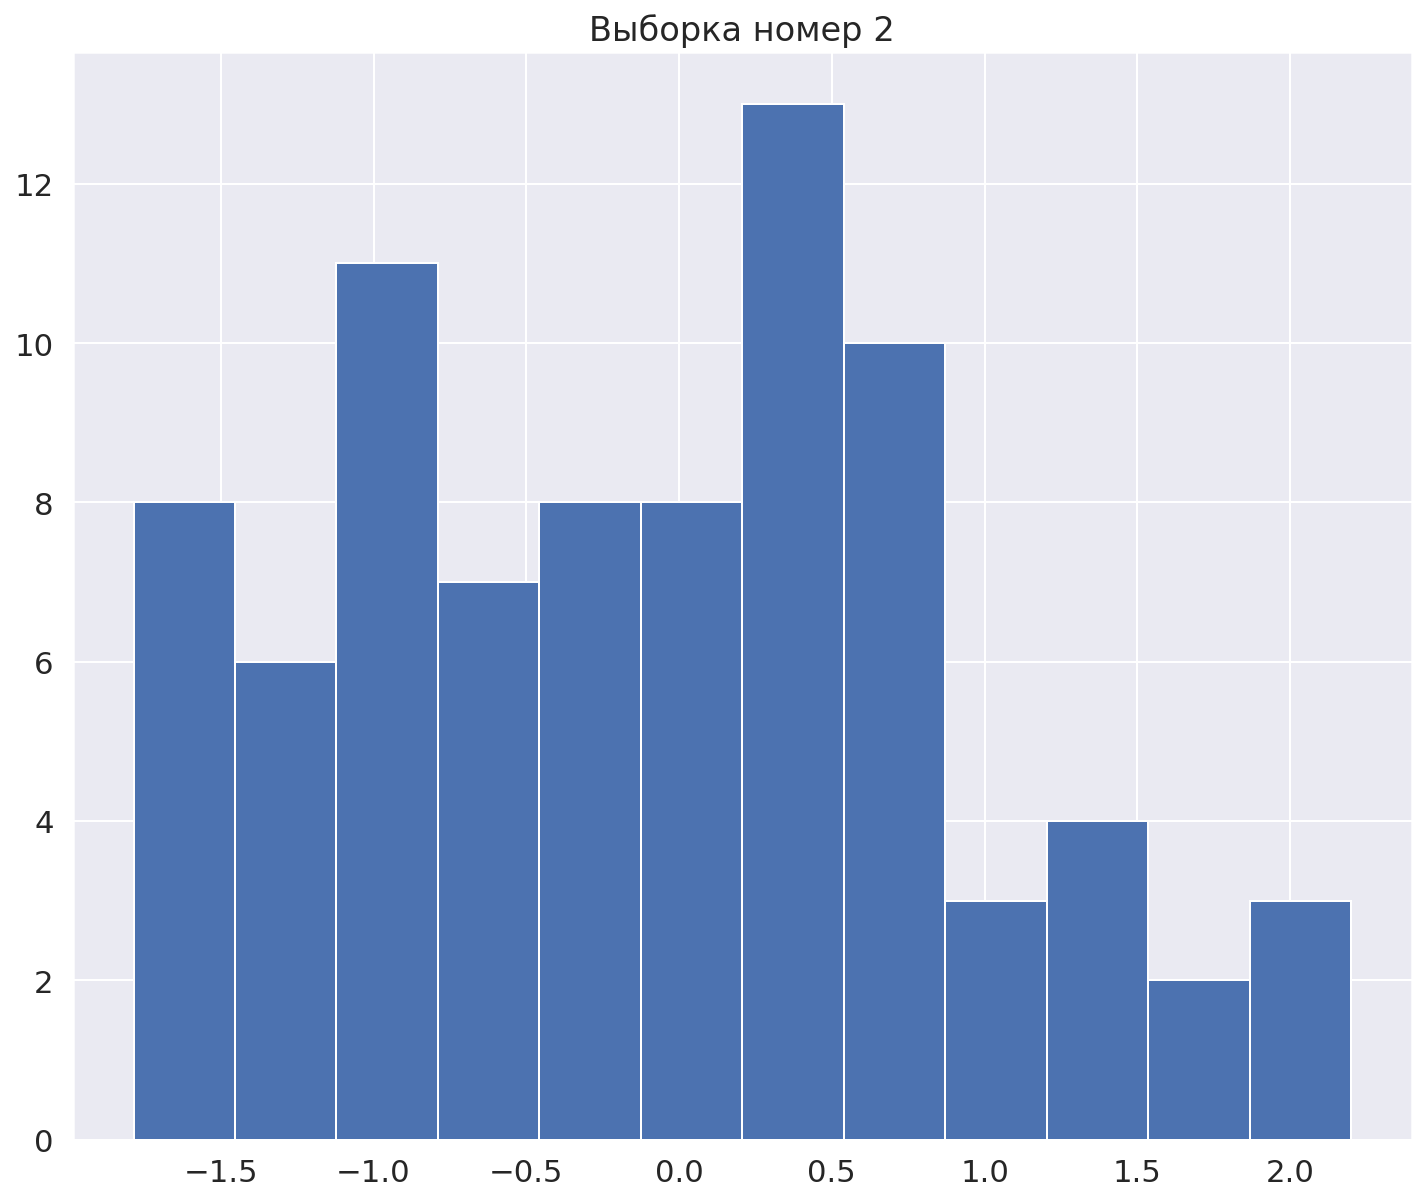

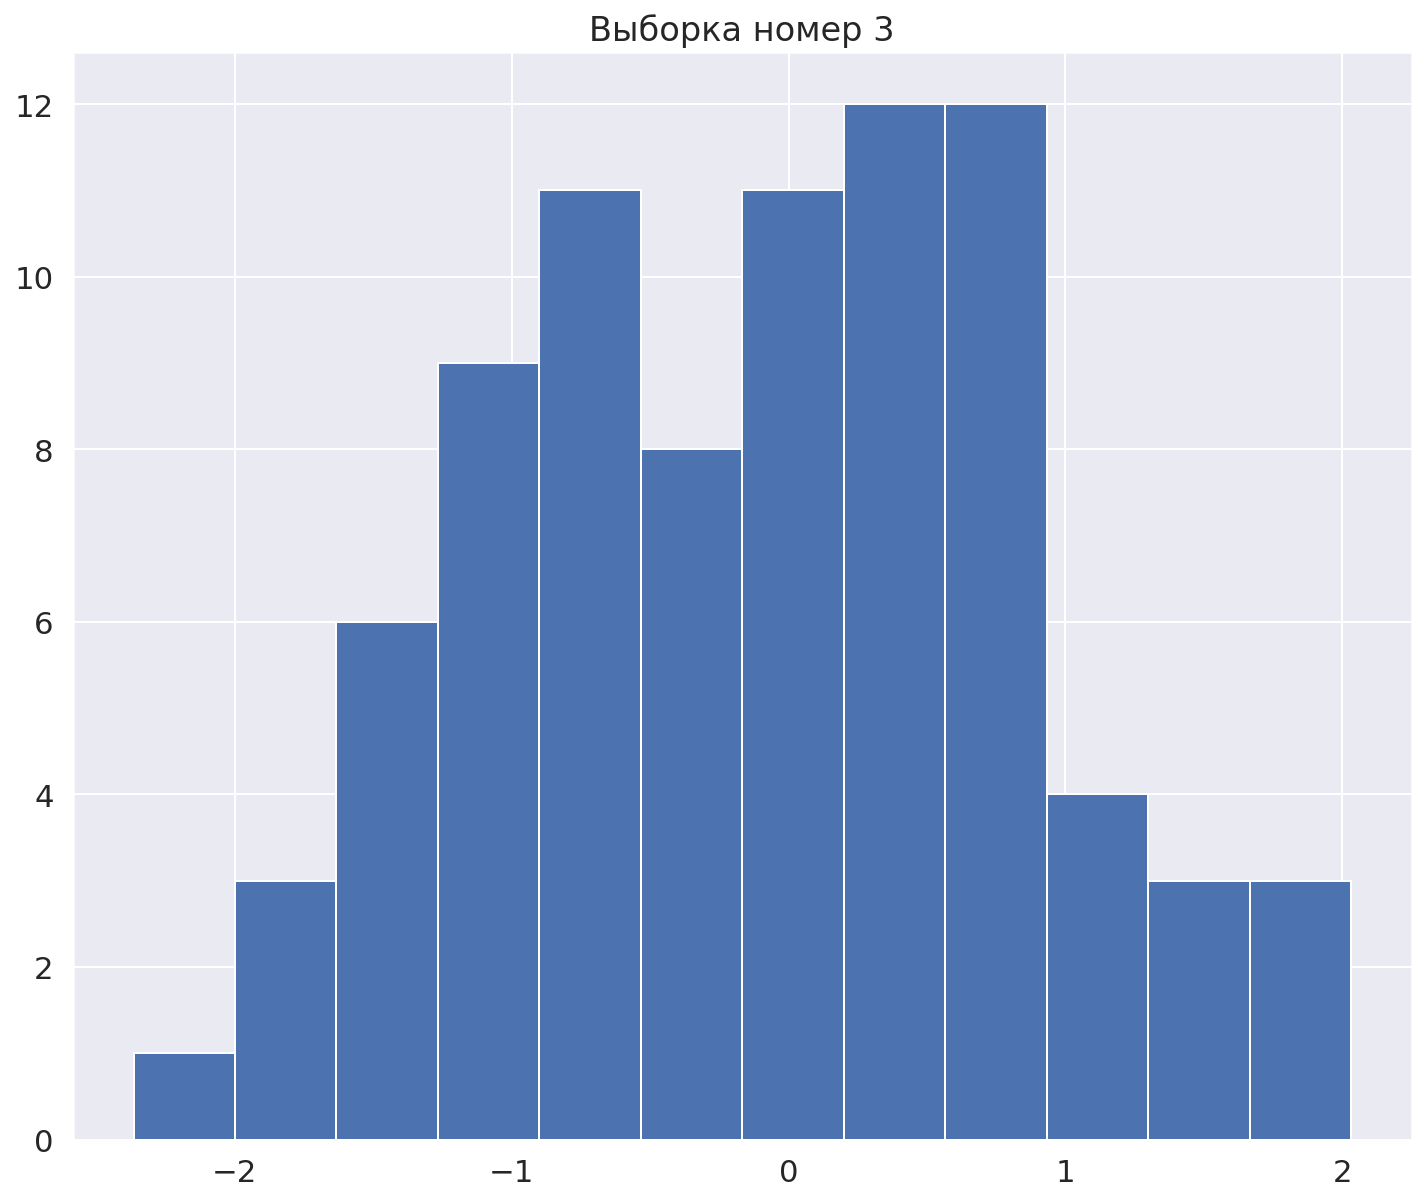

In [116]:
for ind, samp in enumerate(modified_test):
    plt.figure(figsize = (12, 10))
    plt.hist(samp, bins = 12)
    plt.title(f"Выборка номер {ind}")
    plt.show()

Подозрение на нормальность явно есть. Осталось только запустить процедуру множественной проверки гипотез для гипотез о принадлежности выборок стандартному нормальному распределению и $\textbf{независимости}$. В качестве критерия проверки стандартной нормальности будем использовать критерий Колмогорова-Смирнова, а для проверки независимости в совокупности -- коэффициент конкордации. Будем контроллировать FWER на уровне значимости 0.05 с помощью метода Холма.

In [122]:
p_vals = [sps.kstest(samp, sps.norm.cdf)[1] for samp in modified_test]
p_vals

[0.07934538322045483,
 0.5329998613891327,
 0.43672742679980203,
 0.755758365345973]

In [123]:
check_concord_crit(modified_test, 0.05)

Значение статистики -- 102.79518072289157
Гипотеза о независимости в совокупности на уровне 0.05 не отвергается


Как видим, все pvalue  оказались больше 0.05 (при проверки независимости на уровне 0.05 гипотеза не отвеграется, значит и pvalue больше 0.05), а значит очевидно, что все гипотезы отвергаться не будут по методу Холма (как в принципе и по любому другому разумному методу). Значит и гипотезу о принадлежности данной нам исходной выборки многомерному нормальному распределению мы не отвергаем!